In [4]:
!cp /kaggle/input/nn-utils/* .

In [5]:
#!cp /kaggle/input/kaggle-nn-v1-train-1/model.keras .
#!wget https://minecraft-mods.4lima.de/model.keras
!cp /kaggle/input/nn-train-v1/model.weights.h5 .

In [6]:
!pip install tensorflow==2.18.0 keras h5py keras==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have te

In [7]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

#candles = obj_load("/content/NQ_2")[-100000:]
candles = obj_load("/kaggle/input/us-futures-1-minute-candlesticks/NQ_1")#[50000:]
len(candles)

loading /kaggle/input/us-futures-1-minute-candlesticks/NQ_1


99990

In [8]:
#model = tf.keras.models.load_model("model.keras", safe_mode=False, compile=False)
#model.summary()

In [9]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(128)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(64)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(128)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(128)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(64)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(128)(m1_at)

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at])


d = tf.keras.layers.Dense(256)(c)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(256)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(128)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(128)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)




output = tf.keras.layers.Dense(3, activation="softmax", dtype="float32")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0)


model.summary()


# In[10]:



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 94)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 60, 94)         │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 60, 98)         │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 60, 256)        │         25,344 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0],         │
│                           │                        │                │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 60, 98)         │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 60, 128)        │         32,896 │ leaky_re_lu[2][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 60, 256)        │         25,344 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 60, 128)        │         32,896 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 60, 4)          │              0 │ -                      │
├──────────────────────

 Total params: 2,060,547 (7.86 MB)

 Trainable params: 2,060,547 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.load_weights("model.weights.h5")

In [11]:

class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction

In [12]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

              
                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 2):
                #equity += open_profit
                #current_position = Position(0,0,0,0)
                #print("close position:", open_profit)
                current_order = None

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    #sl = sorted_by_low[2][1]
                    tp = entry  -  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, -1)
                        #print("set short order:",entry,sl,tp)
                    if current_position.direction == -1:
                        #current_position.sl = sl
                        current_position.tp = tp



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    #sl = sorted_by_high[2][0]
                    tp = entry  +  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, 1)
                        #print("set long order:",entry,sl,tp)
                    if current_position.direction == 1:
                        #current_position.sl = sl
                        current_position.tp = tp
                        



In [13]:
m = MultiTimeframeCandleManager()

slm = 3
#tpm = 6
tpm = 3


current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  2%|▏         | 2308/99990 [00:00<00:04, 23072.10it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0


  5%|▍         | 4616/99990 [00:01<00:36, 2616.69it/s] 


 -2.25

 -12.75

 3.25

 -81.08749999999782

 -142.63750000000073

 -77.96250000000146

 -65.71250000000146

 -24.075000000000728

 13.262500000000728

 -2.524999999997817

 -240.6875


  6%|▌         | 5662/99990 [00:07<02:57, 530.52it/s] 


 -197.6875

 -292.1375000000007

 -293.5750000000007

 -292.5750000000007

 -210.8125

 -210.8125


  6%|▌         | 6238/99990 [00:10<04:02, 385.91it/s]


 -210.8125

 -220.53749999999854

 -206.92499999999927


  7%|▋         | 6594/99990 [00:13<04:41, 331.63it/s]


 -111.02499999999782

 -83.98749999999927


  7%|▋         | 6828/99990 [00:14<05:08, 301.82it/s]


 -4.6875

 17.012500000000728


  7%|▋         | 6989/99990 [00:15<05:29, 282.59it/s]


 372.1875


  7%|▋         | 7103/99990 [00:15<05:47, 267.16it/s]


 372.1875


  7%|▋         | 7186/99990 [00:16<06:08, 252.07it/s]


 400.8875000000007


  7%|▋         | 7297/99990 [00:17<06:32, 236.12it/s]


 418.33750000000146


  7%|▋         | 7425/99990 [00:17<07:18, 210.92it/s]


 418.33750000000146


  8%|▊         | 7530/99990 [00:18<08:14, 186.83it/s]


 416.33750000000146


  8%|▊         | 7621/99990 [00:18<08:37, 178.62it/s]


 397.15000000000146


  8%|▊         | 7731/99990 [00:19<08:37, 178.19it/s]


 418.8250000000007


  8%|▊         | 7822/99990 [00:20<08:39, 177.45it/s]


 461.7375000000029


  8%|▊         | 7931/99990 [00:20<08:40, 176.94it/s]


 488.13750000000437


  8%|▊         | 8021/99990 [00:21<08:38, 177.37it/s]


 524.4875000000029


  8%|▊         | 8129/99990 [00:21<08:47, 174.23it/s]


 541.4125000000022


  8%|▊         | 8219/99990 [00:22<08:45, 174.64it/s]


 596.375


  8%|▊         | 8328/99990 [00:22<08:39, 176.38it/s]


 745.5750000000007


  8%|▊         | 8436/99990 [00:23<08:33, 178.40it/s]


 745.5750000000007


  9%|▊         | 8526/99990 [00:24<08:39, 176.05it/s]


 745.5750000000007


  9%|▊         | 8636/99990 [00:24<08:32, 178.08it/s]


 869.0750000000007


  9%|▊         | 8726/99990 [00:25<08:35, 177.13it/s]


 911.3374999999978


  9%|▉         | 8817/99990 [00:25<08:46, 173.24it/s]


 910.5874999999978


  9%|▉         | 8925/99990 [00:26<08:39, 175.41it/s]


 866.7499999999964


  9%|▉         | 9033/99990 [00:26<08:39, 175.25it/s]


 869.7374999999956


  9%|▉         | 9125/99990 [00:27<08:29, 178.20it/s]


 862.2874999999949


  9%|▉         | 9235/99990 [00:28<08:24, 179.80it/s]


 859.799999999992


  9%|▉         | 9326/99990 [00:28<08:33, 176.55it/s]


 864.8999999999905


  9%|▉         | 9436/99990 [00:29<08:27, 178.45it/s]


 864.8999999999905


 10%|▉         | 9527/99990 [00:29<08:25, 178.92it/s]


 838.1499999999905


 10%|▉         | 9636/99990 [00:30<08:33, 176.06it/s]


 863.2749999999905


 10%|▉         | 9727/99990 [00:30<08:24, 178.81it/s]


 939.4124999999913


 10%|▉         | 9837/99990 [00:31<08:19, 180.31it/s]


 992.3999999999905


 10%|▉         | 9928/99990 [00:31<08:26, 177.80it/s]


 966.4124999999913


 10%|█         | 10021/99990 [00:32<08:20, 179.64it/s]


 976.112499999992


 10%|█         | 10130/99990 [00:33<08:41, 172.47it/s]


 977.1749999999956


 10%|█         | 10230/99990 [00:33<09:45, 153.34it/s]


 980.6499999999978


 10%|█         | 10327/99990 [00:34<09:42, 153.96it/s]


 993.4375


 10%|█         | 10427/99990 [00:34<09:04, 164.56it/s]


 1008.3624999999993


 11%|█         | 10535/99990 [00:35<08:45, 170.18it/s]


 1008.3624999999993


 11%|█         | 10624/99990 [00:36<08:39, 171.99it/s]


 1008.3624999999993


 11%|█         | 10732/99990 [00:36<08:34, 173.43it/s]


 997.4124999999985


 11%|█         | 10822/99990 [00:37<08:28, 175.33it/s]


 1184.0499999999956


 11%|█         | 10930/99990 [00:37<08:21, 177.59it/s]


 1184.0499999999956


 11%|█         | 11020/99990 [00:38<08:25, 176.02it/s]


 1184.0499999999956


 11%|█         | 11128/99990 [00:39<08:22, 176.88it/s]


 1184.0499999999956


 11%|█         | 11219/99990 [00:39<08:18, 177.98it/s]


 1184.0499999999956


 11%|█▏        | 11327/99990 [00:40<08:20, 177.21it/s]


 1204.9249999999956


 11%|█▏        | 11435/99990 [00:40<08:25, 175.05it/s]


 1213.9999999999964


 12%|█▏        | 11525/99990 [00:41<08:24, 175.48it/s]


 1229.8999999999942


 12%|█▏        | 11633/99990 [00:41<08:19, 176.85it/s]


 1229.8874999999935


 12%|█▏        | 11723/99990 [00:42<08:17, 177.54it/s]


 1236.1249999999927


 12%|█▏        | 11831/99990 [00:42<08:25, 174.56it/s]


 1237.737499999992


 12%|█▏        | 11921/99990 [00:43<08:19, 176.27it/s]


 1225.237499999992


 12%|█▏        | 12029/99990 [00:44<08:23, 174.59it/s]


 1206.8499999999913


 12%|█▏        | 12120/99990 [00:44<08:14, 177.86it/s]


 1291.474999999995


 12%|█▏        | 12228/99990 [00:45<08:23, 174.44it/s]


 1531.5249999999942


 12%|█▏        | 12318/99990 [00:45<08:43, 167.56it/s]


 1531.5249999999942


 12%|█▏        | 12426/99990 [00:46<08:24, 173.57it/s]


 1531.5249999999942


 13%|█▎        | 12534/99990 [00:47<08:22, 173.96it/s]


 1529.2749999999942


 13%|█▎        | 12624/99990 [00:47<08:17, 175.76it/s]


 1529.2749999999942


 13%|█▎        | 12732/99990 [00:48<08:18, 175.20it/s]


 1532.787499999995


 13%|█▎        | 12822/99990 [00:48<08:19, 174.61it/s]


 1540.287499999995


 13%|█▎        | 12930/99990 [00:49<08:28, 171.27it/s]


 1548.6999999999935


 13%|█▎        | 13019/99990 [00:49<08:38, 167.67it/s]


 1604.6374999999935


 13%|█▎        | 13126/99990 [00:50<08:19, 173.85it/s]


 1578.6374999999935


 13%|█▎        | 13234/99990 [00:51<08:11, 176.68it/s]


 1609.162499999995


 13%|█▎        | 13324/99990 [00:51<08:12, 175.98it/s]


 1614.1874999999964


 13%|█▎        | 13432/99990 [00:52<08:09, 176.74it/s]


 1714.3249999999935


 14%|█▎        | 13522/99990 [00:52<08:14, 174.79it/s]


 1764.8999999999942


 14%|█▎        | 13632/99990 [00:53<08:07, 177.29it/s]


 1764.8999999999942


 14%|█▎        | 13722/99990 [00:53<08:22, 171.56it/s]


 1764.8999999999942


 14%|█▍        | 13831/99990 [00:54<08:02, 178.42it/s]


 1764.8999999999942


 14%|█▍        | 13921/99990 [00:54<08:07, 176.50it/s]


 1854.6624999999913


 14%|█▍        | 14029/99990 [00:55<08:11, 175.07it/s]


 1842.049999999992


 14%|█▍        | 14119/99990 [00:56<08:17, 172.55it/s]


 1855.8749999999927


 14%|█▍        | 14228/99990 [00:56<08:02, 177.59it/s]


 1889.1374999999935


 14%|█▍        | 14336/99990 [00:57<08:05, 176.46it/s]


 1892.4374999999927


 14%|█▍        | 14427/99990 [00:57<08:03, 176.78it/s]


 1874.2499999999927


 15%|█▍        | 14535/99990 [00:58<08:10, 174.12it/s]


 1903.8374999999942


 15%|█▍        | 14625/99990 [00:58<08:02, 176.77it/s]


 1903.8374999999942


 15%|█▍        | 14734/99990 [00:59<08:04, 176.05it/s]


 1896.1499999999942


 15%|█▍        | 14824/99990 [01:00<08:02, 176.54it/s]


 1940.8374999999905


 15%|█▍        | 14933/99990 [01:00<08:06, 174.71it/s]


 1890.8374999999905


 15%|█▌        | 15023/99990 [01:01<08:02, 175.94it/s]


 1890.8374999999905


 15%|█▌        | 15133/99990 [01:01<07:53, 179.10it/s]


 1890.8374999999905


 15%|█▌        | 15224/99990 [01:02<08:01, 175.99it/s]


 1851.237499999992


 15%|█▌        | 15332/99990 [01:02<08:03, 175.00it/s]


 1917.5249999999942


 15%|█▌        | 15424/99990 [01:03<07:53, 178.43it/s]


 2039.3374999999905


 16%|█▌        | 15533/99990 [01:04<08:04, 174.25it/s]


 2039.3374999999905


 16%|█▌        | 15625/99990 [01:04<07:52, 178.37it/s]


 2052.0874999999905


 16%|█▌        | 15732/99990 [01:05<08:50, 158.82it/s]


 2101.0874999999905


 16%|█▌        | 15827/99990 [01:05<09:36, 145.90it/s]


 2158.2124999999905


 16%|█▌        | 15926/99990 [01:06<08:46, 159.72it/s]


 2227.69999999999


 16%|█▌        | 16035/99990 [01:07<07:55, 176.73it/s]


 2227.69999999999


 16%|█▌        | 16125/99990 [01:07<07:53, 177.12it/s]


 2208.19999999999


 16%|█▌        | 16234/99990 [01:08<07:56, 175.89it/s]


 2277.57499999999


 16%|█▋        | 16325/99990 [01:08<07:53, 176.81it/s]


 2398.562499999989


 16%|█▋        | 16435/99990 [01:09<07:47, 178.68it/s]


 2520.5999999999876


 17%|█▋        | 16527/99990 [01:09<07:44, 179.54it/s]


 2520.5999999999876


 17%|█▋        | 16635/99990 [01:10<07:57, 174.59it/s]


 2467.449999999986


 17%|█▋        | 16726/99990 [01:11<07:48, 177.84it/s]


 2483.012499999986


 17%|█▋        | 16834/99990 [01:11<07:49, 177.07it/s]


 2471.1249999999854


 17%|█▋        | 16924/99990 [01:12<07:50, 176.51it/s]


 2463.162499999984


 17%|█▋        | 17032/99990 [01:12<07:49, 176.77it/s]


 2475.9499999999825


 17%|█▋        | 17123/99990 [01:13<07:50, 176.27it/s]


 2497.5999999999804


 17%|█▋        | 17231/99990 [01:13<07:53, 174.69it/s]


 2575.262499999979


 17%|█▋        | 17322/99990 [01:14<07:48, 176.27it/s]


 2581.012499999979


 17%|█▋        | 17431/99990 [01:15<07:44, 177.67it/s]


 2560.687499999978


 18%|█▊        | 17522/99990 [01:15<07:42, 178.13it/s]


 2573.462499999976


 18%|█▊        | 17631/99990 [01:16<07:48, 175.69it/s]


 2622.6249999999745


 18%|█▊        | 17721/99990 [01:16<07:44, 177.26it/s]


 2622.6249999999745


 18%|█▊        | 17829/99990 [01:17<07:41, 178.02it/s]


 2622.6249999999745


 18%|█▊        | 17919/99990 [01:17<07:44, 176.70it/s]


 2622.6249999999745


 18%|█▊        | 18027/99990 [01:18<07:51, 173.78it/s]


 2620.1874999999745


 18%|█▊        | 18135/99990 [01:19<07:48, 174.90it/s]


 2604.3749999999745


 18%|█▊        | 18225/99990 [01:19<07:43, 176.27it/s]


 2605.1249999999745


 18%|█▊        | 18333/99990 [01:20<07:51, 173.35it/s]


 2619.849999999973


 18%|█▊        | 18423/99990 [01:20<07:53, 172.12it/s]


 2649.0749999999716


 19%|█▊        | 18531/99990 [01:21<07:49, 173.48it/s]


 2643.6999999999716


 19%|█▊        | 18621/99990 [01:21<07:46, 174.55it/s]


 2719.23749999997


 19%|█▊        | 18729/99990 [01:22<07:46, 174.35it/s]


 2737.92499999997


 19%|█▉        | 18819/99990 [01:23<07:49, 172.72it/s]


 2737.92499999997


 19%|█▉        | 18927/99990 [01:23<07:44, 174.68it/s]


 2835.037499999973


 19%|█▉        | 19036/99990 [01:24<07:41, 175.41it/s]


 2801.7624999999716


 19%|█▉        | 19126/99990 [01:24<07:47, 172.86it/s]


 2856.7624999999716


 19%|█▉        | 19234/99990 [01:25<07:41, 174.80it/s]


 2903.849999999973


 19%|█▉        | 19323/99990 [01:25<08:01, 167.38it/s]


 2999.737499999974


 19%|█▉        | 19431/99990 [01:26<07:43, 173.90it/s]


 3011.737499999974


 20%|█▉        | 19521/99990 [01:27<07:38, 175.34it/s]


 3006.8249999999753


 20%|█▉        | 19629/99990 [01:27<07:38, 175.39it/s]


 3032.5124999999753


 20%|█▉        | 19719/99990 [01:28<07:49, 170.86it/s]


 3013.7624999999753


 20%|█▉        | 19827/99990 [01:28<07:45, 172.13it/s]


 3000.099999999973


 20%|█▉        | 19935/99990 [01:29<07:36, 175.41it/s]


 2984.499999999971


 20%|██        | 20025/99990 [01:29<07:36, 175.18it/s]


 3020.5999999999694


 20%|██        | 20133/99990 [01:30<07:39, 173.62it/s]


 3022.1249999999673


 20%|██        | 20223/99990 [01:31<07:36, 174.78it/s]


 3034.474999999966


 20%|██        | 20331/99990 [01:31<07:34, 175.13it/s]


 3146.649999999965


 20%|██        | 20422/99990 [01:32<07:30, 176.57it/s]


 3344.024999999965


 21%|██        | 20530/99990 [01:32<07:39, 172.81it/s]


 3344.024999999965


 21%|██        | 20620/99990 [01:33<07:40, 172.50it/s]


 3372.662499999966


 21%|██        | 20728/99990 [01:34<07:38, 173.03it/s]


 3334.0749999999643


 21%|██        | 20836/99990 [01:34<07:33, 174.52it/s]


 3331.2499999999636


 21%|██        | 20926/99990 [01:35<07:33, 174.52it/s]


 3290.4624999999614


 21%|██        | 21017/99990 [01:35<07:29, 175.77it/s]


 3323.599999999962


 21%|██        | 21125/99990 [01:36<07:27, 176.27it/s]


 3311.4624999999614


 21%|██        | 21233/99990 [01:36<07:28, 175.47it/s]


 3313.8249999999607


 21%|██▏       | 21332/99990 [01:37<08:32, 153.49it/s]


 3301.1124999999593


 21%|██▏       | 21416/99990 [01:38<08:26, 155.15it/s]


 3272.74999999996


 22%|██▏       | 21535/99990 [01:38<07:51, 166.25it/s]


 3260.49999999996


 22%|██▏       | 21625/99990 [01:39<07:25, 175.73it/s]


 3260.49999999996


 22%|██▏       | 21734/99990 [01:39<07:24, 176.06it/s]


 3161.987499999963


 22%|██▏       | 21824/99990 [01:40<07:26, 175.01it/s]


 3161.987499999963


 22%|██▏       | 21935/99990 [01:41<07:16, 178.94it/s]


 3117.9624999999614


 22%|██▏       | 22025/99990 [01:41<07:20, 177.17it/s]


 3110.4249999999593


 22%|██▏       | 22135/99990 [01:42<07:21, 176.22it/s]


 3088.6749999999593


 22%|██▏       | 22226/99990 [01:42<07:14, 178.91it/s]


 3121.37499999996


 22%|██▏       | 22334/99990 [01:43<07:16, 177.78it/s]


 3108.8374999999614


 22%|██▏       | 22424/99990 [01:43<07:30, 172.29it/s]


 3127.2874999999585


 23%|██▎       | 22532/99990 [01:44<07:20, 175.96it/s]


 3138.4749999999585


 23%|██▎       | 22625/99990 [01:45<07:10, 179.88it/s]


 3186.7999999999593


 23%|██▎       | 22735/99990 [01:45<07:13, 178.19it/s]


 3171.2624999999607


 23%|██▎       | 22825/99990 [01:46<07:22, 174.45it/s]


 3193.7374999999593


 23%|██▎       | 22935/99990 [01:46<07:11, 178.62it/s]


 3197.3874999999607


 23%|██▎       | 23027/99990 [01:47<07:10, 178.58it/s]


 3184.1374999999607


 23%|██▎       | 23120/99990 [01:47<07:09, 179.08it/s]


 3205.6374999999607


 23%|██▎       | 23230/99990 [01:48<07:12, 177.41it/s]


 3205.6374999999607


 23%|██▎       | 23322/99990 [01:48<07:07, 179.19it/s]


 3219.0874999999614


 23%|██▎       | 23433/99990 [01:49<07:06, 179.65it/s]


 3246.1499999999614


 24%|██▎       | 23523/99990 [01:50<07:18, 174.25it/s]


 3302.8374999999614


 24%|██▎       | 23632/99990 [01:50<07:08, 178.01it/s]


 3284.56249999996


 24%|██▎       | 23727/99990 [01:51<07:02, 180.53it/s]


 3284.56249999996


 24%|██▍       | 23822/99990 [01:51<06:59, 181.74it/s]


 3313.2374999999593


 24%|██▍       | 23933/99990 [01:52<07:09, 177.10it/s]


 3265.9249999999593


 24%|██▍       | 24024/99990 [01:52<07:04, 178.91it/s]


 3218.7374999999593


 24%|██▍       | 24134/99990 [01:53<07:03, 178.91it/s]


 3218.7374999999593


 24%|██▍       | 24225/99990 [01:54<07:13, 174.63it/s]


 3218.7374999999593


 24%|██▍       | 24333/99990 [01:54<07:14, 174.08it/s]


 3173.4749999999585


 24%|██▍       | 24423/99990 [01:55<07:17, 172.58it/s]


 3173.4749999999585


 25%|██▍       | 24531/99990 [01:55<07:32, 166.64it/s]


 3173.4749999999585


 25%|██▍       | 24622/99990 [01:56<07:13, 173.84it/s]


 3173.4749999999585


 25%|██▍       | 24730/99990 [01:56<07:09, 175.15it/s]


 3173.4749999999585


 25%|██▍       | 24820/99990 [01:57<07:11, 174.32it/s]


 3207.0749999999607


 25%|██▍       | 24928/99990 [01:58<07:10, 174.23it/s]


 3245.2124999999614


 25%|██▌       | 25018/99990 [01:58<07:21, 169.95it/s]


 3234.1874999999636


 25%|██▌       | 25126/99990 [01:59<07:11, 173.44it/s]


 3234.1874999999636


 25%|██▌       | 25234/99990 [01:59<07:14, 171.88it/s]


 3291.412499999962


 25%|██▌       | 25324/99990 [02:00<07:18, 170.20it/s]


 3267.3874999999643


 25%|██▌       | 25432/99990 [02:00<07:09, 173.53it/s]


 3294.587499999965


 26%|██▌       | 25522/99990 [02:01<07:06, 174.44it/s]


 3294.587499999965


 26%|██▌       | 25630/99990 [02:02<07:03, 175.76it/s]


 3294.587499999965


 26%|██▌       | 25720/99990 [02:02<07:06, 174.17it/s]


 3294.587499999965


 26%|██▌       | 25828/99990 [02:03<07:10, 172.07it/s]


 3275.787499999966


 26%|██▌       | 25918/99990 [02:03<07:15, 170.11it/s]


 3272.0499999999665


 26%|██▌       | 26026/99990 [02:04<07:05, 173.97it/s]


 3272.9999999999673


 26%|██▌       | 26134/99990 [02:05<07:07, 172.91it/s]


 3281.6874999999673


 26%|██▌       | 26224/99990 [02:05<07:08, 172.03it/s]


 3258.3624999999665


 26%|██▋       | 26332/99990 [02:06<07:10, 170.94it/s]


 3326.599999999966


 26%|██▋       | 26422/99990 [02:06<07:07, 172.23it/s]


 3326.599999999966


 27%|██▋       | 26530/99990 [02:07<07:13, 169.49it/s]


 3366.962499999965


 27%|██▋       | 26620/99990 [02:07<06:59, 174.92it/s]


 3406.424999999963


 27%|██▋       | 26728/99990 [02:08<07:02, 173.45it/s]


 3375.737499999963


 27%|██▋       | 26817/99990 [02:09<07:34, 160.84it/s]


 3375.737499999963


 27%|██▋       | 26931/99990 [02:09<07:57, 152.87it/s]


 3403.237499999963


 27%|██▋       | 27028/99990 [02:10<07:47, 155.93it/s]


 3562.462499999965


 27%|██▋       | 27133/99990 [02:11<07:05, 171.21it/s]


 3605.087499999965


 27%|██▋       | 27223/99990 [02:11<07:00, 172.88it/s]


 3616.4249999999665


 27%|██▋       | 27331/99990 [02:12<07:04, 171.31it/s]


 3621.1249999999673


 27%|██▋       | 27421/99990 [02:12<07:00, 172.65it/s]


 3610.4624999999687


 28%|██▊       | 27529/99990 [02:13<06:56, 173.91it/s]


 3608.124999999971


 28%|██▊       | 27619/99990 [02:13<07:03, 170.87it/s]


 3638.4124999999694


 28%|██▊       | 27727/99990 [02:14<06:52, 175.15it/s]


 3661.11249999997


 28%|██▊       | 27835/99990 [02:15<06:55, 173.83it/s]


 3689.61249999997


 28%|██▊       | 27925/99990 [02:15<06:56, 172.89it/s]


 3704.61249999997


 28%|██▊       | 28033/99990 [02:16<06:58, 172.00it/s]


 3727.7874999999694


 28%|██▊       | 28123/99990 [02:16<06:48, 176.04it/s]


 3727.7874999999694


 28%|██▊       | 28232/99990 [02:17<06:46, 176.36it/s]


 3727.7874999999694


 28%|██▊       | 28322/99990 [02:17<06:44, 177.03it/s]


 3727.7874999999694


 28%|██▊       | 28430/99990 [02:18<06:53, 172.88it/s]


 3759.749999999971


 29%|██▊       | 28520/99990 [02:19<06:49, 174.61it/s]


 3763.98749999997


 29%|██▊       | 28628/99990 [02:19<06:47, 174.98it/s]


 3767.23749999997


 29%|██▊       | 28736/99990 [02:20<06:44, 176.10it/s]


 3756.2249999999694


 29%|██▉       | 28826/99990 [02:20<06:44, 176.04it/s]


 3756.2249999999694


 29%|██▉       | 28934/99990 [02:21<06:42, 176.58it/s]


 3761.2374999999665


 29%|██▉       | 29024/99990 [02:21<06:42, 176.12it/s]


 3825.0374999999694


 29%|██▉       | 29132/99990 [02:22<06:42, 175.95it/s]


 3825.0374999999694


 29%|██▉       | 29222/99990 [02:22<06:40, 176.72it/s]


 3825.0374999999694


 29%|██▉       | 29330/99990 [02:23<06:43, 175.08it/s]


 3889.1499999999687


 29%|██▉       | 29420/99990 [02:24<06:49, 172.15it/s]


 3908.8124999999673


 30%|██▉       | 29529/99990 [02:24<06:47, 172.97it/s]


 3951.4249999999665


 30%|██▉       | 29619/99990 [02:25<06:39, 175.97it/s]


 3951.4249999999665


 30%|██▉       | 29728/99990 [02:25<07:02, 166.27it/s]


 3951.4249999999665


 30%|██▉       | 29836/99990 [02:26<06:39, 175.41it/s]


 3951.4249999999665


 30%|██▉       | 29926/99990 [02:27<06:34, 177.50it/s]


 3955.4249999999665


 30%|███       | 30035/99990 [02:27<06:34, 177.27it/s]


 3943.0374999999694


 30%|███       | 30125/99990 [02:28<06:40, 174.25it/s]


 3943.0374999999694


 30%|███       | 30233/99990 [02:28<06:40, 174.00it/s]


 3933.2874999999694


 30%|███       | 30323/99990 [02:29<06:34, 176.40it/s]


 3883.5374999999694


 30%|███       | 30431/99990 [02:29<06:35, 175.74it/s]


 3899.699999999968


 31%|███       | 30521/99990 [02:30<06:38, 174.27it/s]


 3912.199999999968


 31%|███       | 30631/99990 [02:31<06:30, 177.64it/s]


 3928.8499999999694


 31%|███       | 30721/99990 [02:31<06:32, 176.44it/s]


 3957.387499999968


 31%|███       | 30830/99990 [02:32<06:36, 174.32it/s]


 3997.012499999968


 31%|███       | 30920/99990 [02:32<06:33, 175.58it/s]


 3997.012499999968


 31%|███       | 31028/99990 [02:33<06:39, 172.50it/s]


 3997.012499999968


 31%|███       | 31118/99990 [02:33<06:42, 171.21it/s]


 3963.0499999999665


 31%|███       | 31226/99990 [02:34<06:33, 174.58it/s]


 3944.762499999968


 31%|███▏      | 31334/99990 [02:35<06:30, 175.92it/s]


 3944.762499999968


 31%|███▏      | 31424/99990 [02:35<06:29, 176.24it/s]


 3933.762499999968


 32%|███▏      | 31532/99990 [02:36<06:37, 172.04it/s]


 3937.762499999968


 32%|███▏      | 31624/99990 [02:36<06:34, 173.49it/s]


 3950.762499999968


 32%|███▏      | 31732/99990 [02:37<06:25, 176.98it/s]


 3992.349999999966


 32%|███▏      | 31822/99990 [02:37<06:23, 177.75it/s]


 3989.712499999965


 32%|███▏      | 31930/99990 [02:38<06:28, 175.22it/s]


 3991.3874999999643


 32%|███▏      | 32021/99990 [02:38<06:25, 176.27it/s]


 4027.487499999963


 32%|███▏      | 32129/99990 [02:39<06:25, 176.02it/s]


 4099.162499999962


 32%|███▏      | 32219/99990 [02:40<06:20, 177.98it/s]


 4125.449999999961


 32%|███▏      | 32327/99990 [02:40<06:25, 175.29it/s]


 4138.237499999959


 32%|███▏      | 32431/99990 [02:41<07:11, 156.46it/s]


 4190.7874999999585


 33%|███▎      | 32529/99990 [02:42<07:01, 160.06it/s]


 4109.024999999961


 33%|███▎      | 32629/99990 [02:42<06:54, 162.70it/s]


 4109.024999999961


 33%|███▎      | 32719/99990 [02:43<06:27, 173.61it/s]


 4091.112499999963


 33%|███▎      | 32827/99990 [02:43<06:28, 172.95it/s]


 4155.399999999961


 33%|███▎      | 32936/99990 [02:44<06:16, 177.92it/s]


 4155.824999999961


 33%|███▎      | 33026/99990 [02:44<06:18, 176.80it/s]


 4185.799999999959


 33%|███▎      | 33134/99990 [02:45<06:14, 178.76it/s]


 4173.149999999958


 33%|███▎      | 33224/99990 [02:46<06:25, 173.34it/s]


 4204.562499999956


 33%|███▎      | 33332/99990 [02:46<06:15, 177.49it/s]


 4305.4124999999585


 33%|███▎      | 33423/99990 [02:47<06:14, 177.70it/s]


 4305.4124999999585


 34%|███▎      | 33532/99990 [02:47<06:13, 177.70it/s]


 4305.4124999999585


 34%|███▎      | 33622/99990 [02:48<06:18, 175.21it/s]


 4228.549999999959


 34%|███▎      | 33730/99990 [02:48<06:19, 174.59it/s]


 4212.949999999957


 34%|███▍      | 33820/99990 [02:49<06:16, 175.58it/s]


 4262.24999999996


 34%|███▍      | 33928/99990 [02:50<06:22, 172.65it/s]


 4258.24999999996


 34%|███▍      | 34036/99990 [02:50<06:15, 175.73it/s]


 4252.324999999961


 34%|███▍      | 34127/99990 [02:51<06:09, 178.06it/s]


 4237.599999999962


 34%|███▍      | 34235/99990 [02:51<06:13, 176.26it/s]


 4249.299999999959


 34%|███▍      | 34326/99990 [02:52<06:08, 178.09it/s]


 4259.149999999958


 34%|███▍      | 34436/99990 [02:52<06:08, 177.95it/s]


 4259.149999999958


 35%|███▍      | 34526/99990 [02:53<06:11, 176.29it/s]


 4268.12499999996


 35%|███▍      | 34635/99990 [02:54<06:13, 175.18it/s]


 4247.8499999999585


 35%|███▍      | 34725/99990 [02:54<06:09, 176.58it/s]


 4321.74999999996


 35%|███▍      | 34834/99990 [02:55<06:07, 177.41it/s]


 4321.74999999996


 35%|███▍      | 34924/99990 [02:55<06:09, 176.24it/s]


 4321.74999999996


 35%|███▌      | 35032/99990 [02:56<06:09, 176.02it/s]


 4284.87499999996


 35%|███▌      | 35122/99990 [02:56<06:08, 176.13it/s]


 4275.37499999996


 35%|███▌      | 35230/99990 [02:57<06:06, 176.56it/s]


 4273.262499999961


 35%|███▌      | 35321/99990 [02:57<06:03, 177.70it/s]


 4275.4749999999585


 35%|███▌      | 35429/99990 [02:58<06:11, 173.63it/s]


 4259.962499999958


 36%|███▌      | 35519/99990 [02:59<06:09, 174.63it/s]


 4269.074999999957


 36%|███▌      | 35627/99990 [02:59<06:08, 174.76it/s]


 4338.962499999958


 36%|███▌      | 35735/99990 [03:00<06:08, 174.22it/s]


 4329.712499999958


 36%|███▌      | 35825/99990 [03:00<06:02, 177.18it/s]


 4362.512499999961


 36%|███▌      | 35933/99990 [03:01<06:07, 174.54it/s]


 4362.512499999961


 36%|███▌      | 36023/99990 [03:01<06:02, 176.23it/s]


 4362.512499999961


 36%|███▌      | 36131/99990 [03:02<06:01, 176.43it/s]


 4398.762499999961


 36%|███▌      | 36221/99990 [03:03<06:08, 172.91it/s]


 4423.774999999961


 36%|███▋      | 36329/99990 [03:03<06:05, 174.12it/s]


 4442.337499999961


 36%|███▋      | 36419/99990 [03:04<06:04, 174.41it/s]


 4437.337499999961


 37%|███▋      | 36530/99990 [03:04<06:02, 174.86it/s]


 4488.824999999961


 37%|███▋      | 36620/99990 [03:05<05:57, 177.04it/s]


 4528.287499999962


 37%|███▋      | 36729/99990 [03:05<06:09, 171.42it/s]


 4545.537499999962


 37%|███▋      | 36822/99990 [03:06<05:53, 178.52it/s]


 4519.824999999961


 37%|███▋      | 36935/99990 [03:07<05:46, 181.93it/s]


 4535.612499999963


 37%|███▋      | 37030/99990 [03:07<05:48, 180.65it/s]


 4535.612499999963


 37%|███▋      | 37123/99990 [03:08<05:50, 179.38it/s]


 4535.612499999963


 37%|███▋      | 37234/99990 [03:08<05:51, 178.54it/s]


 4535.612499999963


 37%|███▋      | 37328/99990 [03:09<05:48, 179.71it/s]


 4566.37499999996


 37%|███▋      | 37420/99990 [03:09<05:48, 179.29it/s]


 4566.37499999996


 38%|███▊      | 37531/99990 [03:10<05:51, 177.81it/s]


 4596.987499999959


 38%|███▊      | 37623/99990 [03:10<05:46, 180.18it/s]


 4568.362499999959


 38%|███▊      | 37736/99990 [03:11<05:48, 178.66it/s]


 4601.3499999999585


 38%|███▊      | 37827/99990 [03:12<05:47, 179.03it/s]


 4625.93749999996


 38%|███▊      | 37921/99990 [03:12<05:44, 180.15it/s]


 4632.18749999996


 38%|███▊      | 38029/99990 [03:13<06:32, 157.83it/s]


 4644.962499999961


 38%|███▊      | 38129/99990 [03:13<06:37, 155.71it/s]


 4730.68749999996


 38%|███▊      | 38230/99990 [03:14<06:08, 167.65it/s]


 4839.1624999999585


 38%|███▊      | 38324/99990 [03:15<05:45, 178.63it/s]


 4900.549999999959


 38%|███▊      | 38433/99990 [03:15<05:48, 176.46it/s]


 4786.412499999962


 39%|███▊      | 38523/99990 [03:16<05:56, 172.45it/s]


 4786.412499999962


 39%|███▊      | 38631/99990 [03:16<05:48, 176.12it/s]


 4722.474999999966


 39%|███▊      | 38721/99990 [03:17<05:45, 177.08it/s]


 4757.012499999968


 39%|███▉      | 38829/99990 [03:17<05:45, 177.01it/s]


 4757.012499999968


 39%|███▉      | 38919/99990 [03:18<05:53, 172.66it/s]


 4717.249999999971


 39%|███▉      | 39027/99990 [03:19<05:49, 174.63it/s]


 4781.837499999972


 39%|███▉      | 39136/99990 [03:19<05:44, 176.55it/s]


 4753.262499999972


 39%|███▉      | 39226/99990 [03:20<05:46, 175.51it/s]


 4731.574999999972


 39%|███▉      | 39334/99990 [03:20<05:41, 177.40it/s]


 4759.11249999997


 39%|███▉      | 39424/99990 [03:21<05:46, 174.98it/s]


 4760.374999999971


 40%|███▉      | 39532/99990 [03:21<05:45, 175.20it/s]


 4777.349999999969


 40%|███▉      | 39622/99990 [03:22<05:45, 174.57it/s]


 4855.149999999969


 40%|███▉      | 39730/99990 [03:23<05:43, 175.26it/s]


 4855.149999999969


 40%|███▉      | 39821/99990 [03:23<05:43, 175.07it/s]


 4924.062499999967


 40%|███▉      | 39929/99990 [03:24<05:44, 174.20it/s]


 4929.537499999966


 40%|████      | 40020/99990 [03:24<05:46, 173.16it/s]


 5082.849999999966


 40%|████      | 40129/99990 [03:25<05:37, 177.11it/s]


 5082.849999999966


 40%|████      | 40219/99990 [03:25<05:52, 169.67it/s]


 5082.849999999966


 40%|████      | 40327/99990 [03:26<05:38, 176.06it/s]


 5113.4874999999665


 40%|████      | 40435/99990 [03:27<05:41, 174.41it/s]


 5151.937499999967


 41%|████      | 40525/99990 [03:27<05:38, 175.83it/s]


 5143.474999999966


 41%|████      | 40635/99990 [03:28<05:37, 175.91it/s]


 5157.1749999999665


 41%|████      | 40725/99990 [03:28<05:39, 174.74it/s]


 5177.499999999967


 41%|████      | 40833/99990 [03:29<05:35, 176.20it/s]


 5111.312499999967


 41%|████      | 40923/99990 [03:29<05:34, 176.60it/s]


 5138.1124999999665


 41%|████      | 41031/99990 [03:30<05:37, 174.82it/s]


 5188.899999999969


 41%|████      | 41121/99990 [03:31<05:35, 175.25it/s]


 5202.324999999968


 41%|████      | 41229/99990 [03:31<05:33, 176.09it/s]


 5210.524999999969


 41%|████▏     | 41319/99990 [03:32<05:30, 177.28it/s]


 5241.637499999968


 41%|████▏     | 41428/99990 [03:32<05:34, 175.24it/s]


 5289.687499999964


 42%|████▏     | 41518/99990 [03:33<05:31, 176.40it/s]


 5310.187499999964


 42%|████▏     | 41626/99990 [03:33<05:37, 172.81it/s]


 5328.074999999964


 42%|████▏     | 41734/99990 [03:34<05:32, 174.98it/s]


 5361.324999999964


 42%|████▏     | 41824/99990 [03:35<05:32, 174.90it/s]


 5361.324999999964


 42%|████▏     | 41932/99990 [03:35<05:32, 174.67it/s]


 5336.762499999964


 42%|████▏     | 42023/99990 [03:36<05:35, 172.81it/s]


 5336.762499999964


 42%|████▏     | 42132/99990 [03:36<05:31, 174.47it/s]


 5338.6124999999665


 42%|████▏     | 42222/99990 [03:37<05:26, 176.70it/s]


 5329.9874999999665


 42%|████▏     | 42331/99990 [03:37<05:25, 176.94it/s]


 5290.212499999965


 42%|████▏     | 42421/99990 [03:38<05:28, 175.01it/s]


 5330.299999999963


 43%|████▎     | 42529/99990 [03:39<05:30, 173.97it/s]


 5297.799999999963


 43%|████▎     | 42619/99990 [03:39<05:27, 175.33it/s]


 5237.024999999965


 43%|████▎     | 42730/99990 [03:40<05:21, 178.12it/s]


 5220.187499999967


 43%|████▎     | 42820/99990 [03:40<05:25, 175.66it/s]


 5067.724999999966


 43%|████▎     | 42928/99990 [03:41<05:23, 176.55it/s]


 5067.724999999966


 43%|████▎     | 43036/99990 [03:41<05:22, 176.36it/s]


 5076.374999999967


 43%|████▎     | 43126/99990 [03:42<05:24, 175.42it/s]


 5077.337499999969


 43%|████▎     | 43235/99990 [03:43<05:22, 176.25it/s]


 5077.337499999969


 43%|████▎     | 43325/99990 [03:43<05:28, 172.45it/s]


 5077.337499999969


 43%|████▎     | 43433/99990 [03:44<05:25, 173.81it/s]


 5077.337499999969


 44%|████▎     | 43523/99990 [03:44<05:41, 165.18it/s]


 5088.949999999968


 44%|████▎     | 43622/99990 [03:45<05:58, 157.03it/s]


 5086.98749999997


 44%|████▎     | 43719/99990 [03:46<06:01, 155.48it/s]


 5111.48749999997


 44%|████▍     | 43822/99990 [03:46<05:32, 169.04it/s]


 5076.474999999969


 44%|████▍     | 43930/99990 [03:47<05:18, 175.92it/s]


 5065.012499999968


 44%|████▍     | 44020/99990 [03:47<05:18, 175.62it/s]


 5038.024999999969


 44%|████▍     | 44128/99990 [03:48<05:17, 176.15it/s]


 4990.624999999967


 44%|████▍     | 44236/99990 [03:49<05:18, 175.31it/s]


 4990.624999999967


 44%|████▍     | 44326/99990 [03:49<05:19, 174.38it/s]


 5042.7999999999665


 44%|████▍     | 44434/99990 [03:50<05:25, 170.47it/s]


 5108.7374999999665


 45%|████▍     | 44524/99990 [03:50<05:20, 173.29it/s]


 5191.262499999968


 45%|████▍     | 44632/99990 [03:51<05:15, 175.73it/s]


 5108.137499999968


 45%|████▍     | 44723/99990 [03:51<05:11, 177.20it/s]


 5168.8624999999665


 45%|████▍     | 44831/99990 [03:52<05:12, 176.37it/s]


 5199.399999999965


 45%|████▍     | 44921/99990 [03:52<05:12, 176.45it/s]


 5184.699999999964


 45%|████▌     | 45029/99990 [03:53<05:13, 175.19it/s]


 5136.787499999962


 45%|████▌     | 45119/99990 [03:54<05:14, 174.51it/s]


 5162.787499999962


 45%|████▌     | 45228/99990 [03:54<05:14, 174.29it/s]


 5097.962499999961


 45%|████▌     | 45336/99990 [03:55<05:10, 175.99it/s]


 5159.487499999963


 45%|████▌     | 45426/99990 [03:55<05:27, 166.70it/s]


 5188.949999999964


 46%|████▌     | 45534/99990 [03:56<05:12, 174.12it/s]


 5227.199999999964


 46%|████▌     | 45625/99990 [03:56<05:07, 176.95it/s]


 5227.199999999964


 46%|████▌     | 45733/99990 [03:57<05:06, 176.90it/s]


 5206.199999999964


 46%|████▌     | 45823/99990 [03:58<05:06, 176.46it/s]


 5206.699999999964


 46%|████▌     | 45931/99990 [03:58<05:10, 174.02it/s]


 5149.762499999964


 46%|████▌     | 46021/99990 [03:59<05:11, 173.23it/s]


 5226.462499999965


 46%|████▌     | 46129/99990 [03:59<05:06, 175.52it/s]


 5226.462499999965


 46%|████▌     | 46219/99990 [04:00<05:11, 172.55it/s]


 5139.024999999965


 46%|████▋     | 46328/99990 [04:00<05:02, 177.46it/s]


 5031.724999999962


 46%|████▋     | 46436/99990 [04:01<05:05, 175.04it/s]


 4957.124999999964


 47%|████▋     | 46527/99990 [04:02<05:01, 177.35it/s]


 4975.874999999964


 47%|████▋     | 46635/99990 [04:02<05:01, 176.95it/s]


 4966.812499999964


 47%|████▋     | 46726/99990 [04:03<05:00, 177.22it/s]


 4894.749999999964


 47%|████▋     | 46834/99990 [04:03<05:09, 171.80it/s]


 4826.599999999966


 47%|████▋     | 46924/99990 [04:04<05:03, 175.13it/s]


 4769.0499999999665


 47%|████▋     | 47032/99990 [04:04<04:58, 177.59it/s]


 4732.912499999966


 47%|████▋     | 47122/99990 [04:05<04:59, 176.75it/s]


 4676.462499999969


 47%|████▋     | 47230/99990 [04:06<05:05, 172.65it/s]


 4664.012499999968


 47%|████▋     | 47319/99990 [04:06<05:15, 166.97it/s]


 4639.312499999967


 47%|████▋     | 47427/99990 [04:07<05:00, 174.83it/s]


 4655.124999999967


 48%|████▊     | 47535/99990 [04:07<04:55, 177.81it/s]


 4655.124999999967


 48%|████▊     | 47626/99990 [04:08<04:57, 175.98it/s]


 4638.574999999968


 48%|████▊     | 47735/99990 [04:09<04:56, 176.36it/s]


 4591.324999999968


 48%|████▊     | 47825/99990 [04:09<04:57, 175.46it/s]


 4561.312499999964


 48%|████▊     | 47933/99990 [04:10<05:00, 173.32it/s]


 4561.312499999964


 48%|████▊     | 48023/99990 [04:10<04:58, 174.07it/s]


 4569.274999999965


 48%|████▊     | 48132/99990 [04:11<04:51, 178.12it/s]


 4611.912499999966


 48%|████▊     | 48222/99990 [04:11<04:53, 176.26it/s]


 4589.399999999969


 48%|████▊     | 48330/99990 [04:12<04:57, 173.36it/s]


 4589.399999999969


 48%|████▊     | 48420/99990 [04:12<04:52, 176.50it/s]


 4544.249999999967


 49%|████▊     | 48528/99990 [04:13<04:55, 173.89it/s]


 4497.712499999965


 49%|████▊     | 48636/99990 [04:14<04:58, 171.95it/s]


 4603.312499999964


 49%|████▊     | 48726/99990 [04:14<04:55, 173.40it/s]


 4595.724999999962


 49%|████▉     | 48834/99990 [04:15<04:51, 175.53it/s]


 4584.299999999963


 49%|████▉     | 48924/99990 [04:15<05:05, 167.35it/s]


 4584.299999999963


 49%|████▉     | 49032/99990 [04:16<04:50, 175.42it/s]


 4597.099999999962


 49%|████▉     | 49119/99990 [04:17<05:25, 156.52it/s]


 4591.674999999963


 49%|████▉     | 49218/99990 [04:17<05:16, 160.26it/s]


 4592.812499999964


 49%|████▉     | 49319/99990 [04:18<05:17, 159.50it/s]


 4592.812499999964


 49%|████▉     | 49425/99990 [04:18<04:52, 172.78it/s]


 4592.812499999964


 50%|████▉     | 49533/99990 [04:19<04:48, 174.74it/s]


 4587.512499999964


 50%|████▉     | 49624/99990 [04:20<04:43, 177.95it/s]


 4524.874999999967


 50%|████▉     | 49732/99990 [04:20<04:45, 175.82it/s]


 4524.874999999967


 50%|████▉     | 49822/99990 [04:21<04:47, 174.63it/s]


 4512.6749999999665


 50%|████▉     | 49930/99990 [04:21<04:46, 174.64it/s]


 4553.512499999968


 50%|█████     | 50020/99990 [04:22<04:44, 175.58it/s]


 4553.512499999968


 50%|█████     | 50128/99990 [04:22<04:41, 177.33it/s]


 4573.874999999967


 50%|█████     | 50236/99990 [04:23<04:44, 175.13it/s]


 4573.874999999967


 50%|█████     | 50326/99990 [04:24<04:47, 172.57it/s]


 4573.874999999967


 50%|█████     | 50435/99990 [04:24<04:42, 175.28it/s]


 4573.874999999967


 51%|█████     | 50525/99990 [04:25<04:39, 176.85it/s]


 4545.912499999966


 51%|█████     | 50616/99990 [04:25<04:46, 172.54it/s]


 4556.212499999965


 51%|█████     | 50725/99990 [04:26<04:41, 174.87it/s]


 4555.974999999966


 51%|█████     | 50834/99990 [04:26<04:37, 177.04it/s]


 4525.912499999966


 51%|█████     | 50927/99990 [04:27<04:33, 179.55it/s]


 4614.54999999997


 51%|█████     | 51022/99990 [04:27<04:28, 182.05it/s]


 4554.449999999972


 51%|█████     | 51135/99990 [04:28<04:32, 179.18it/s]


 4554.449999999972


 51%|█████     | 51229/99990 [04:29<04:34, 177.44it/s]


 4554.449999999972


 51%|█████▏    | 51322/99990 [04:29<04:30, 179.88it/s]


 4554.449999999972


 51%|█████▏    | 51435/99990 [04:30<04:34, 176.72it/s]


 4530.499999999971


 52%|█████▏    | 51527/99990 [04:30<04:30, 179.24it/s]


 4517.837499999972


 52%|█████▏    | 51636/99990 [04:31<04:29, 179.39it/s]


 4506.762499999972


 52%|█████▏    | 51728/99990 [04:31<04:28, 179.90it/s]


 4514.262499999972


 52%|█████▏    | 51823/99990 [04:32<04:24, 181.77it/s]


 4521.86249999997


 52%|█████▏    | 51937/99990 [04:33<04:27, 179.83it/s]


 4519.587499999972


 52%|█████▏    | 52032/99990 [04:33<04:28, 178.43it/s]


 4509.187499999971


 52%|█████▏    | 52122/99990 [04:34<04:32, 175.67it/s]


 4497.287499999969


 52%|█████▏    | 52232/99990 [04:34<04:30, 176.65it/s]


 4543.974999999969


 52%|█████▏    | 52323/99990 [04:35<04:27, 177.89it/s]


 4485.649999999969


 52%|█████▏    | 52431/99990 [04:35<04:45, 166.39it/s]


 4493.649999999969


 53%|█████▎    | 52522/99990 [04:36<04:28, 176.85it/s]


 4456.874999999971


 53%|█████▎    | 52630/99990 [04:37<04:29, 175.54it/s]


 4469.974999999969


 53%|█████▎    | 52720/99990 [04:37<04:31, 174.39it/s]


 4449.11249999997


 53%|█████▎    | 52828/99990 [04:38<04:33, 172.44it/s]


 4453.48749999997


 53%|█████▎    | 52936/99990 [04:38<04:30, 173.88it/s]


 4487.974999999969


 53%|█████▎    | 53026/99990 [04:39<04:29, 174.25it/s]


 4487.974999999969


 53%|█████▎    | 53134/99990 [04:39<04:26, 175.50it/s]


 4491.037499999966


 53%|█████▎    | 53224/99990 [04:40<04:27, 174.61it/s]


 4478.237499999963


 53%|█████▎    | 53333/99990 [04:41<04:22, 177.51it/s]


 4495.974999999962


 53%|█████▎    | 53423/99990 [04:41<04:22, 177.09it/s]


 4499.599999999962


 54%|█████▎    | 53531/99990 [04:42<04:25, 174.70it/s]


 4497.437499999964


 54%|█████▎    | 53621/99990 [04:42<04:23, 175.84it/s]


 4504.249999999964


 54%|█████▎    | 53729/99990 [04:43<04:21, 177.04it/s]


 4556.112499999963


 54%|█████▍    | 53821/99990 [04:43<04:29, 171.59it/s]


 4586.524999999965


 54%|█████▍    | 53929/99990 [04:44<04:22, 175.71it/s]


 4532.6124999999665


 54%|█████▍    | 54019/99990 [04:44<04:22, 175.41it/s]


 4541.6124999999665


 54%|█████▍    | 54128/99990 [04:45<04:21, 175.19it/s]


 4569.099999999969


 54%|█████▍    | 54236/99990 [04:46<04:23, 173.97it/s]


 4563.437499999967


 54%|█████▍    | 54326/99990 [04:46<04:17, 177.68it/s]


 4589.962499999969


 54%|█████▍    | 54436/99990 [04:47<04:15, 178.41it/s]


 4577.349999999966


 55%|█████▍    | 54526/99990 [04:47<04:16, 177.22it/s]


 4552.362499999963


 55%|█████▍    | 54634/99990 [04:48<04:19, 174.88it/s]


 4547.462499999961


 55%|█████▍    | 54721/99990 [04:49<04:45, 158.29it/s]


 4547.562499999964


 55%|█████▍    | 54820/99990 [04:49<04:48, 156.37it/s]


 4521.162499999962


 55%|█████▍    | 54933/99990 [04:50<04:44, 158.30it/s]


 4519.24999999996


 55%|█████▌    | 55023/99990 [04:50<04:17, 174.71it/s]


 4594.4749999999585


 55%|█████▌    | 55132/99990 [04:51<04:10, 178.84it/s]


 4645.99999999996


 55%|█████▌    | 55224/99990 [04:52<04:08, 179.85it/s]


 4619.299999999959


 55%|█████▌    | 55334/99990 [04:52<04:11, 177.29it/s]


 4631.68749999996


 55%|█████▌    | 55424/99990 [04:53<04:12, 176.15it/s]


 4597.237499999959


 56%|█████▌    | 55533/99990 [04:53<04:18, 172.15it/s]


 4586.524999999961


 56%|█████▌    | 55623/99990 [04:54<04:12, 175.79it/s]


 4590.924999999963


 56%|█████▌    | 55731/99990 [04:54<04:12, 175.33it/s]


 4611.287499999962


 56%|█████▌    | 55822/99990 [04:55<04:07, 178.48it/s]


 4601.212499999961


 56%|█████▌    | 55930/99990 [04:56<04:15, 172.38it/s]


 4592.487499999959


 56%|█████▌    | 56020/99990 [04:56<04:08, 176.77it/s]


 4671.224999999962


 56%|█████▌    | 56128/99990 [04:57<04:09, 176.08it/s]


 4677.974999999962


 56%|█████▌    | 56236/99990 [04:57<04:09, 175.62it/s]


 4652.362499999963


 56%|█████▋    | 56328/99990 [04:58<04:05, 178.03it/s]


 4626.874999999964


 56%|█████▋    | 56436/99990 [04:58<04:08, 174.96it/s]


 4579.899999999965


 57%|█████▋    | 56526/99990 [04:59<04:06, 176.27it/s]


 4573.899999999965


 57%|█████▋    | 56636/99990 [05:00<04:02, 178.64it/s]


 4585.587499999965


 57%|█████▋    | 56726/99990 [05:00<04:06, 175.47it/s]


 4527.274999999965


 57%|█████▋    | 56834/99990 [05:01<04:06, 175.05it/s]


 4530.474999999966


 57%|█████▋    | 56924/99990 [05:01<04:08, 173.28it/s]


 4563.262499999964


 57%|█████▋    | 57032/99990 [05:02<04:09, 172.47it/s]


 4572.562499999964


 57%|█████▋    | 57122/99990 [05:02<04:06, 173.88it/s]


 4583.399999999965


 57%|█████▋    | 57230/99990 [05:03<04:04, 174.92it/s]


 4560.774999999969


 57%|█████▋    | 57320/99990 [05:03<04:09, 171.17it/s]


 4517.374999999971


 57%|█████▋    | 57430/99990 [05:04<04:01, 176.30it/s]


 4520.124999999971


 58%|█████▊    | 57520/99990 [05:05<04:00, 176.61it/s]


 4565.787499999969


 58%|█████▊    | 57628/99990 [05:05<04:10, 169.44it/s]


 4585.437499999971


 58%|█████▊    | 57735/99990 [05:06<04:01, 175.03it/s]


 4538.137499999972


 58%|█████▊    | 57825/99990 [05:06<03:58, 176.51it/s]


 4510.899999999972


 58%|█████▊    | 57933/99990 [05:07<03:57, 177.11it/s]


 4481.899999999972


 58%|█████▊    | 58023/99990 [05:07<03:57, 176.35it/s]


 4500.612499999974


 58%|█████▊    | 58132/99990 [05:08<03:56, 177.23it/s]


 4416.9374999999745


 58%|█████▊    | 58222/99990 [05:09<03:56, 176.84it/s]


 4404.9999999999745


 58%|█████▊    | 58330/99990 [05:09<03:58, 174.40it/s]


 4388.674999999974


 58%|█████▊    | 58420/99990 [05:10<03:55, 176.73it/s]


 4392.162499999973


 59%|█████▊    | 58529/99990 [05:10<03:53, 177.29it/s]


 4369.462499999976


 59%|█████▊    | 58619/99990 [05:11<03:55, 175.34it/s]


 4372.1249999999745


 59%|█████▊    | 58728/99990 [05:11<03:53, 176.64it/s]


 4389.8749999999745


 59%|█████▉    | 58836/99990 [05:12<03:55, 174.90it/s]


 4361.399999999972


 59%|█████▉    | 58928/99990 [05:13<03:51, 177.06it/s]


 4334.024999999972


 59%|█████▉    | 59018/99990 [05:13<03:53, 175.51it/s]


 4320.849999999969


 59%|█████▉    | 59126/99990 [05:14<03:55, 173.36it/s]


 4350.399999999969


 59%|█████▉    | 59234/99990 [05:14<03:53, 174.44it/s]


 4334.437499999967


 59%|█████▉    | 59324/99990 [05:15<03:50, 176.55it/s]


 4342.962499999969


 59%|█████▉    | 59432/99990 [05:16<03:58, 170.22it/s]


 4323.274999999969


 60%|█████▉    | 59522/99990 [05:16<03:50, 175.83it/s]


 4316.387499999968


 60%|█████▉    | 59630/99990 [05:17<03:49, 175.73it/s]


 4309.262499999968


 60%|█████▉    | 59720/99990 [05:17<03:48, 176.22it/s]


 4320.912499999969


 60%|█████▉    | 59828/99990 [05:18<03:48, 176.04it/s]


 4311.437499999971


 60%|█████▉    | 59918/99990 [05:18<03:48, 175.24it/s]


 4311.437499999971


 60%|██████    | 60027/99990 [05:19<03:48, 175.24it/s]


 4319.212499999972


 60%|██████    | 60135/99990 [05:20<03:46, 175.98it/s]


 4295.012499999968


 60%|██████    | 60225/99990 [05:20<03:49, 172.92it/s]


 4400.312499999967


 60%|██████    | 60328/99990 [05:21<04:07, 159.97it/s]


 4424.437499999967


 60%|██████    | 60427/99990 [05:21<04:11, 157.58it/s]


 4424.437499999967


 61%|██████    | 60526/99990 [05:22<04:04, 161.37it/s]


 4417.662499999966


 61%|██████    | 60634/99990 [05:23<03:50, 170.93it/s]


 4397.762499999964


 61%|██████    | 60724/99990 [05:23<03:48, 172.20it/s]


 4381.524999999965


 61%|██████    | 60831/99990 [05:24<03:46, 172.90it/s]


 4361.699999999964


 61%|██████    | 60921/99990 [05:24<03:47, 171.90it/s]


 4359.949999999964


 61%|██████    | 61029/99990 [05:25<03:41, 175.93it/s]


 4361.012499999964


 61%|██████    | 61119/99990 [05:25<03:54, 165.94it/s]


 4357.837499999965


 61%|██████    | 61228/99990 [05:26<03:39, 176.49it/s]


 4352.062499999964


 61%|██████▏   | 61336/99990 [05:27<03:40, 175.69it/s]


 4346.312499999964


 61%|██████▏   | 61426/99990 [05:27<03:40, 175.09it/s]


 4323.287499999962


 62%|██████▏   | 61534/99990 [05:28<03:44, 171.42it/s]


 4329.549999999963


 62%|██████▏   | 61624/99990 [05:28<03:39, 175.10it/s]


 4377.337499999961


 62%|██████▏   | 61732/99990 [05:29<03:38, 175.05it/s]


 4377.337499999961


 62%|██████▏   | 61822/99990 [05:29<03:37, 175.84it/s]


 4377.337499999961


 62%|██████▏   | 61930/99990 [05:30<03:37, 174.82it/s]


 4409.774999999961


 62%|██████▏   | 62021/99990 [05:31<03:36, 175.32it/s]


 4409.524999999961


 62%|██████▏   | 62129/99990 [05:31<03:34, 176.69it/s]


 4401.012499999961


 62%|██████▏   | 62219/99990 [05:32<03:37, 174.03it/s]


 4374.837499999958


 62%|██████▏   | 62327/99990 [05:32<03:33, 176.50it/s]


 4379.3499999999585


 62%|██████▏   | 62435/99990 [05:33<03:33, 175.73it/s]


 4359.799999999959


 63%|██████▎   | 62525/99990 [05:33<03:40, 170.24it/s]


 4336.074999999961


 63%|██████▎   | 62633/99990 [05:34<03:33, 175.35it/s]


 4341.12499999996


 63%|██████▎   | 62723/99990 [05:35<03:33, 174.36it/s]


 4349.87499999996


 63%|██████▎   | 62832/99990 [05:35<03:35, 172.52it/s]


 4339.174999999963


 63%|██████▎   | 62922/99990 [05:36<03:35, 172.40it/s]


 4334.649999999965


 63%|██████▎   | 63030/99990 [05:36<03:33, 173.21it/s]


 4300.374999999964


 63%|██████▎   | 63120/99990 [05:37<03:30, 175.00it/s]


 4300.374999999964


 63%|██████▎   | 63228/99990 [05:37<03:29, 175.49it/s]


 4295.374999999964


 63%|██████▎   | 63318/99990 [05:38<03:30, 173.91it/s]


 4252.874999999964


 63%|██████▎   | 63426/99990 [05:39<03:28, 175.78it/s]


 4211.037499999962


 64%|██████▎   | 63534/99990 [05:39<03:26, 176.24it/s]


 4243.924999999963


 64%|██████▎   | 63624/99990 [05:40<03:26, 175.74it/s]


 4229.387499999964


 64%|██████▎   | 63732/99990 [05:40<03:28, 173.62it/s]


 4246.887499999964


 64%|██████▍   | 63822/99990 [05:41<03:27, 174.40it/s]


 4248.924999999963


 64%|██████▍   | 63930/99990 [05:42<03:26, 174.28it/s]


 4245.612499999963


 64%|██████▍   | 64020/99990 [05:42<03:26, 174.53it/s]


 4228.062499999964


 64%|██████▍   | 64128/99990 [05:43<03:24, 175.72it/s]


 4239.249999999964


 64%|██████▍   | 64219/99990 [05:43<03:21, 177.71it/s]


 4229.662499999966


 64%|██████▍   | 64327/99990 [05:44<03:24, 174.51it/s]


 4313.049999999963


 64%|██████▍   | 64435/99990 [05:44<03:24, 174.01it/s]


 4313.049999999963


 65%|██████▍   | 64525/99990 [05:45<03:22, 175.39it/s]


 4313.049999999963


 65%|██████▍   | 64633/99990 [05:46<03:26, 170.96it/s]


 4313.049999999963


 65%|██████▍   | 64723/99990 [05:46<03:20, 175.73it/s]


 4339.524999999961


 65%|██████▍   | 64831/99990 [05:47<03:20, 175.67it/s]


 4334.987499999963


 65%|██████▍   | 64921/99990 [05:47<03:18, 176.54it/s]


 4367.174999999963


 65%|██████▌   | 65029/99990 [05:48<03:18, 175.95it/s]


 4367.174999999963


 65%|██████▌   | 65119/99990 [05:48<03:17, 176.22it/s]


 4339.174999999963


 65%|██████▌   | 65227/99990 [05:49<03:16, 177.07it/s]


 4389.387499999964


 65%|██████▌   | 65335/99990 [05:50<03:16, 176.48it/s]


 4368.074999999964


 65%|██████▌   | 65425/99990 [05:50<03:18, 173.74it/s]


 4383.749999999964


 66%|██████▌   | 65533/99990 [05:51<03:16, 175.58it/s]


 4401.499999999964


 66%|██████▌   | 65625/99990 [05:51<03:12, 178.54it/s]


 4364.874999999964


 66%|██████▌   | 65735/99990 [05:52<03:11, 179.12it/s]


 4311.174999999963


 66%|██████▌   | 65823/99990 [05:52<03:38, 156.14it/s]


 4311.174999999963


 66%|██████▌   | 65923/99990 [05:53<03:34, 158.69it/s]


 4279.762499999964


 66%|██████▌   | 66020/99990 [05:54<03:41, 153.52it/s]


 4356.724999999966


 66%|██████▌   | 66128/99990 [05:54<03:14, 174.45it/s]


 4358.849999999966


 66%|██████▌   | 66237/99990 [05:55<03:09, 178.19it/s]


 4348.224999999966


 66%|██████▋   | 66328/99990 [05:55<03:18, 169.92it/s]


 4348.724999999966


 66%|██████▋   | 66420/99990 [05:56<03:08, 177.94it/s]


 4336.187499999967


 67%|██████▋   | 66529/99990 [05:56<03:07, 178.21it/s]


 4351.2999999999665


 67%|██████▋   | 66619/99990 [05:57<03:08, 177.27it/s]


 4387.887499999968


 67%|██████▋   | 66727/99990 [05:58<03:07, 177.66it/s]


 4387.887499999968


 67%|██████▋   | 66835/99990 [05:58<03:08, 176.04it/s]


 4344.587499999969


 67%|██████▋   | 66926/99990 [05:59<03:07, 175.92it/s]


 4330.937499999967


 67%|██████▋   | 67034/99990 [05:59<03:05, 177.26it/s]


 4180.312499999967


 67%|██████▋   | 67124/99990 [06:00<03:07, 175.18it/s]


 4165.324999999968


 67%|██████▋   | 67234/99990 [06:00<03:03, 178.43it/s]


 4165.324999999968


 67%|██████▋   | 67324/99990 [06:01<03:04, 176.75it/s]


 4165.324999999968


 67%|██████▋   | 67432/99990 [06:02<03:04, 176.13it/s]


 4154.562499999967


 68%|██████▊   | 67522/99990 [06:02<03:03, 176.93it/s]


 4085.937499999971


 68%|██████▊   | 67630/99990 [06:03<03:05, 174.74it/s]


 4097.962499999969


 68%|██████▊   | 67721/99990 [06:03<03:05, 174.35it/s]


 4099.712499999969


 68%|██████▊   | 67829/99990 [06:04<03:04, 174.24it/s]


 4093.074999999968


 68%|██████▊   | 67919/99990 [06:04<03:06, 172.20it/s]


 4069.1124999999665


 68%|██████▊   | 68027/99990 [06:05<03:03, 173.81it/s]


 4047.8624999999665


 68%|██████▊   | 68134/99990 [06:06<03:04, 172.36it/s]


 4021.837499999965


 68%|██████▊   | 68224/99990 [06:06<03:00, 176.03it/s]


 3999.1374999999643


 68%|██████▊   | 68332/99990 [06:07<02:58, 177.13it/s]


 4056.1374999999643


 68%|██████▊   | 68423/99990 [06:07<02:57, 177.87it/s]


 3984.9374999999673


 69%|██████▊   | 68532/99990 [06:08<02:58, 176.05it/s]


 3984.9374999999673


 69%|██████▊   | 68622/99990 [06:08<02:59, 174.73it/s]


 3984.9374999999673


 69%|██████▊   | 68730/99990 [06:09<02:57, 175.73it/s]


 3984.9374999999673


 69%|██████▉   | 68821/99990 [06:10<02:56, 177.09it/s]


 3952.5249999999687


 69%|██████▉   | 68930/99990 [06:10<02:55, 177.33it/s]


 3958.5249999999687


 69%|██████▉   | 69021/99990 [06:11<02:54, 177.67it/s]


 3921.98749999997


 69%|██████▉   | 69130/99990 [06:11<02:52, 178.58it/s]


 3915.687499999971


 69%|██████▉   | 69220/99990 [06:12<02:57, 173.44it/s]


 3890.2749999999724


 69%|██████▉   | 69328/99990 [06:12<02:54, 175.25it/s]


 3873.7624999999716


 69%|██████▉   | 69420/99990 [06:13<02:51, 178.67it/s]


 3885.749999999971


 70%|██████▉   | 69528/99990 [06:14<02:54, 174.47it/s]


 3885.749999999971


 70%|██████▉   | 69637/99990 [06:14<02:51, 176.93it/s]


 3885.749999999971


 70%|██████▉   | 69728/99990 [06:15<02:50, 177.81it/s]


 3973.374999999971


 70%|██████▉   | 69818/99990 [06:15<02:52, 174.80it/s]


 4157.037499999969


 70%|██████▉   | 69926/99990 [06:16<02:52, 174.65it/s]


 4157.037499999969


 70%|███████   | 70034/99990 [06:16<02:52, 173.83it/s]


 4157.037499999969


 70%|███████   | 70124/99990 [06:17<02:50, 175.23it/s]


 4157.037499999969


 70%|███████   | 70233/99990 [06:18<02:50, 174.84it/s]


 4161.999999999971


 70%|███████   | 70324/99990 [06:18<02:52, 172.41it/s]


 4218.074999999972


 70%|███████   | 70433/99990 [06:19<02:47, 176.17it/s]


 4234.437499999971


 71%|███████   | 70524/99990 [06:20<03:54, 125.90it/s]


 4234.437499999971


 71%|███████   | 70631/99990 [06:20<02:54, 168.25it/s]


 4244.249999999971


 71%|███████   | 70722/99990 [06:21<02:45, 176.51it/s]


 4327.749999999971


 71%|███████   | 70830/99990 [06:21<02:44, 177.10it/s]


 4320.599999999969


 71%|███████   | 70920/99990 [06:22<02:45, 175.86it/s]


 4324.349999999969


 71%|███████   | 71028/99990 [06:22<02:45, 175.22it/s]


 4295.749999999971


 71%|███████   | 71136/99990 [06:23<02:43, 176.85it/s]


 4207.349999999969


 71%|███████   | 71226/99990 [06:24<02:45, 173.38it/s]


 4292.712499999969


 71%|███████▏  | 71316/99990 [06:24<02:53, 165.11it/s]


 4292.712499999969


 71%|███████▏  | 71431/99990 [06:25<03:04, 155.08it/s]


 4292.712499999969


 72%|███████▏  | 71528/99990 [06:25<03:08, 151.18it/s]


 4170.98749999997


 72%|███████▏  | 71632/99990 [06:26<02:46, 170.38it/s]


 4250.86249999997


 72%|███████▏  | 71722/99990 [06:27<02:42, 174.20it/s]


 4214.949999999972


 72%|███████▏  | 71830/99990 [06:27<02:39, 176.79it/s]


 4214.949999999972


 72%|███████▏  | 71920/99990 [06:28<02:40, 175.34it/s]


 4255.999999999971


 72%|███████▏  | 72028/99990 [06:28<02:39, 175.28it/s]


 4262.999999999967


 72%|███████▏  | 72136/99990 [06:29<02:39, 174.31it/s]


 4239.287499999969


 72%|███████▏  | 72226/99990 [06:29<02:37, 176.29it/s]


 4239.287499999969


 72%|███████▏  | 72334/99990 [06:30<02:37, 175.16it/s]


 4314.887499999968


 72%|███████▏  | 72424/99990 [06:31<02:39, 173.31it/s]


 4309.349999999966


 73%|███████▎  | 72533/99990 [06:31<02:35, 177.10it/s]


 4543.349999999966


 73%|███████▎  | 72624/99990 [06:32<02:33, 177.77it/s]


 4543.349999999966


 73%|███████▎  | 72732/99990 [06:32<02:34, 176.84it/s]


 4608.687499999967


 73%|███████▎  | 72822/99990 [06:33<02:35, 174.75it/s]


 4872.3624999999665


 73%|███████▎  | 72930/99990 [06:33<02:39, 169.75it/s]


 4903.374999999967


 73%|███████▎  | 73020/99990 [06:34<02:34, 174.48it/s]


 4907.212499999969


 73%|███████▎  | 73128/99990 [06:35<02:33, 175.20it/s]


 4907.212499999969


 73%|███████▎  | 73218/99990 [06:35<02:34, 173.06it/s]


 4907.212499999969


 73%|███████▎  | 73325/99990 [06:36<02:34, 172.04it/s]


 4916.474999999966


 73%|███████▎  | 73433/99990 [06:36<02:33, 172.51it/s]


 4914.4249999999665


 74%|███████▎  | 73523/99990 [06:37<02:33, 172.93it/s]


 4861.337499999965


 74%|███████▎  | 73631/99990 [06:38<02:32, 173.19it/s]


 4900.837499999965


 74%|███████▎  | 73721/99990 [06:38<02:31, 173.71it/s]


 5037.337499999965


 74%|███████▍  | 73829/99990 [06:39<02:31, 172.53it/s]


 5047.312499999964


 74%|███████▍  | 73919/99990 [06:39<02:29, 174.36it/s]


 4933.474999999962


 74%|███████▍  | 74027/99990 [06:40<02:30, 172.42it/s]


 4933.474999999962


 74%|███████▍  | 74135/99990 [06:40<02:28, 174.17it/s]


 4933.474999999962


 74%|███████▍  | 74225/99990 [06:41<02:26, 175.66it/s]


 4774.31249999996


 74%|███████▍  | 74333/99990 [06:42<02:26, 175.00it/s]


 4743.56249999996


 74%|███████▍  | 74423/99990 [06:42<02:25, 175.96it/s]


 4699.737499999959


 75%|███████▍  | 74531/99990 [06:43<02:24, 176.23it/s]


 4640.899999999958


 75%|███████▍  | 74621/99990 [06:43<02:23, 176.47it/s]


 4648.399999999958


 75%|███████▍  | 74729/99990 [06:44<02:26, 172.03it/s]


 4588.737499999956


 75%|███████▍  | 74819/99990 [06:44<02:25, 173.48it/s]


 4584.849999999955


 75%|███████▍  | 74927/99990 [06:45<02:22, 175.36it/s]


 4607.212499999954


 75%|███████▌  | 75035/99990 [06:46<02:25, 171.75it/s]


 4618.274999999954


 75%|███████▌  | 75125/99990 [06:46<02:21, 175.86it/s]


 4687.487499999952


 75%|███████▌  | 75234/99990 [06:47<02:19, 177.21it/s]


 4726.762499999953


 75%|███████▌  | 75324/99990 [06:47<02:19, 176.56it/s]


 4726.762499999953


 75%|███████▌  | 75432/99990 [06:48<02:21, 174.15it/s]


 4726.762499999953


 76%|███████▌  | 75522/99990 [06:48<02:20, 174.03it/s]


 4587.9624999999505


 76%|███████▌  | 75630/99990 [06:49<02:18, 176.15it/s]


 4632.749999999949


 76%|███████▌  | 75720/99990 [06:49<02:18, 175.10it/s]


 4579.424999999952


 76%|███████▌  | 75827/99990 [06:50<02:23, 168.06it/s]


 4615.062499999953


 76%|███████▌  | 75935/99990 [06:51<02:18, 174.22it/s]


 4629.574999999953


 76%|███████▌  | 76025/99990 [06:51<02:18, 172.92it/s]


 4640.074999999953


 76%|███████▌  | 76133/99990 [06:52<02:18, 172.58it/s]


 4630.062499999953


 76%|███████▌  | 76223/99990 [06:52<02:18, 171.96it/s]


 4724.249999999953


 76%|███████▋  | 76331/99990 [06:53<02:16, 173.68it/s]


 4724.249999999953


 76%|███████▋  | 76420/99990 [06:54<02:18, 170.32it/s]


 4724.249999999953


 77%|███████▋  | 76528/99990 [06:54<02:17, 170.59it/s]


 4582.13749999995


 77%|███████▋  | 76636/99990 [06:55<02:14, 174.14it/s]


 4754.924999999948


 77%|███████▋  | 76725/99990 [06:55<02:19, 166.44it/s]


 4850.499999999949


 77%|███████▋  | 76833/99990 [06:56<02:18, 167.48it/s]


 4850.499999999949


 77%|███████▋  | 76931/99990 [06:57<02:32, 151.30it/s]


 4850.499999999949


 77%|███████▋  | 77031/99990 [06:57<02:21, 161.91it/s]


 4862.499999999949


 77%|███████▋  | 77132/99990 [06:58<02:21, 161.36it/s]


 4854.662499999951


 77%|███████▋  | 77221/99990 [06:58<02:13, 171.09it/s]


 4859.9624999999505


 77%|███████▋  | 77329/99990 [06:59<02:12, 171.13it/s]


 4844.4624999999505


 77%|███████▋  | 77419/99990 [07:00<02:09, 173.95it/s]


 4905.474999999951


 78%|███████▊  | 77527/99990 [07:00<02:09, 174.03it/s]


 4881.812499999953


 78%|███████▊  | 77635/99990 [07:01<02:07, 175.80it/s]


 4909.974999999951


 78%|███████▊  | 77725/99990 [07:01<02:07, 175.20it/s]


 4848.737499999952


 78%|███████▊  | 77833/99990 [07:02<02:06, 175.82it/s]


 4829.237499999956


 78%|███████▊  | 77923/99990 [07:02<02:04, 177.39it/s]


 4751.137499999957


 78%|███████▊  | 78032/99990 [07:03<02:03, 178.34it/s]


 4680.187499999956


 78%|███████▊  | 78122/99990 [07:04<02:04, 176.16it/s]


 4680.187499999956


 78%|███████▊  | 78230/99990 [07:04<02:04, 174.36it/s]


 4680.187499999956


 78%|███████▊  | 78320/99990 [07:05<02:02, 177.24it/s]


 4680.187499999956


 78%|███████▊  | 78428/99990 [07:05<02:08, 167.85it/s]


 4680.187499999956


 79%|███████▊  | 78537/99990 [07:06<02:00, 178.11it/s]


 4680.187499999956


 79%|███████▊  | 78627/99990 [07:06<02:00, 177.41it/s]


 4680.187499999956


 79%|███████▊  | 78735/99990 [07:07<02:00, 176.83it/s]


 4673.187499999956


 79%|███████▉  | 78825/99990 [07:08<02:00, 175.12it/s]


 4679.912499999955


 79%|███████▉  | 78933/99990 [07:08<02:03, 169.87it/s]


 4664.312499999956


 79%|███████▉  | 79022/99990 [07:09<02:01, 172.19it/s]


 4704.712499999958


 79%|███████▉  | 79130/99990 [07:09<02:00, 172.62it/s]


 4639.137499999957


 79%|███████▉  | 79220/99990 [07:10<02:02, 169.65it/s]


 4598.774999999958


 79%|███████▉  | 79328/99990 [07:10<02:00, 171.22it/s]


 4469.887499999961


 79%|███████▉  | 79418/99990 [07:11<02:00, 171.18it/s]


 4469.887499999961


 80%|███████▉  | 79526/99990 [07:12<01:59, 171.24it/s]


 4469.887499999961


 80%|███████▉  | 79634/99990 [07:12<01:58, 172.35it/s]


 4469.887499999961


 80%|███████▉  | 79724/99990 [07:13<01:58, 171.35it/s]


 4379.512499999957


 80%|███████▉  | 79832/99990 [07:13<01:58, 170.36it/s]


 4372.924999999956


 80%|███████▉  | 79922/99990 [07:14<01:57, 170.37it/s]


 4372.924999999956


 80%|████████  | 80030/99990 [07:15<01:55, 172.50it/s]


 4372.924999999956


 80%|████████  | 80120/99990 [07:15<01:55, 171.35it/s]


 4383.174999999956


 80%|████████  | 80227/99990 [07:16<01:56, 170.14it/s]


 4399.624999999956


 80%|████████  | 80335/99990 [07:16<01:53, 173.41it/s]


 4408.924999999956


 80%|████████  | 80425/99990 [07:17<01:51, 174.95it/s]


 4440.424999999956


 81%|████████  | 80532/99990 [07:18<01:53, 170.86it/s]


 4408.999999999956


 81%|████████  | 80622/99990 [07:18<01:52, 171.58it/s]


 4315.812499999956


 81%|████████  | 80730/99990 [07:19<01:52, 171.77it/s]


 4243.287499999955


 81%|████████  | 80820/99990 [07:19<01:52, 170.94it/s]


 4243.287499999955


 81%|████████  | 80928/99990 [07:20<01:50, 173.18it/s]


 4243.287499999955


 81%|████████  | 81036/99990 [07:20<01:47, 176.67it/s]


 4407.287499999955


 81%|████████  | 81126/99990 [07:21<01:48, 174.59it/s]


 4453.674999999956


 81%|████████  | 81234/99990 [07:22<01:47, 174.47it/s]


 4491.424999999956


 81%|████████▏ | 81324/99990 [07:22<01:46, 175.14it/s]


 4447.137499999957


 81%|████████▏ | 81432/99990 [07:23<01:46, 174.55it/s]


 4430.262499999957


 82%|████████▏ | 81522/99990 [07:23<01:48, 170.60it/s]


 4410.237499999956


 82%|████████▏ | 81630/99990 [07:24<01:45, 174.31it/s]


 4368.249999999953


 82%|████████▏ | 81720/99990 [07:24<01:45, 172.41it/s]


 4336.474999999951


 82%|████████▏ | 81828/99990 [07:25<01:43, 176.02it/s]


 4282.837499999954


 82%|████████▏ | 81936/99990 [07:26<01:45, 171.40it/s]


 4323.337499999954


 82%|████████▏ | 82026/99990 [07:26<01:42, 174.75it/s]


 4110.124999999953


 82%|████████▏ | 82134/99990 [07:27<01:41, 175.36it/s]


 4253.212499999954


 82%|████████▏ | 82224/99990 [07:27<01:41, 174.81it/s]


 4240.212499999954


 82%|████████▏ | 82332/99990 [07:28<01:45, 167.97it/s]


 4136.699999999953


 82%|████████▏ | 82431/99990 [07:29<01:52, 156.22it/s]


 4249.374999999953


 83%|████████▎ | 82530/99990 [07:29<01:53, 153.70it/s]


 4202.424999999956


 83%|████████▎ | 82630/99990 [07:30<01:46, 162.63it/s]


 4161.812499999953


 83%|████████▎ | 82720/99990 [07:30<01:38, 174.91it/s]


 4143.812499999953


 83%|████████▎ | 82828/99990 [07:31<01:38, 175.04it/s]


 4143.812499999953


 83%|████████▎ | 82918/99990 [07:31<01:38, 173.23it/s]


 4135.099999999951


 83%|████████▎ | 83026/99990 [07:32<01:38, 172.66it/s]


 4182.449999999953


 83%|████████▎ | 83134/99990 [07:33<01:37, 173.49it/s]


 4182.449999999953


 83%|████████▎ | 83224/99990 [07:33<01:37, 171.61it/s]


 4158.812499999953


 83%|████████▎ | 83332/99990 [07:34<01:35, 175.21it/s]


 4164.874999999949


 83%|████████▎ | 83422/99990 [07:34<01:35, 173.85it/s]


 4177.44999999995


 84%|████████▎ | 83530/99990 [07:35<01:33, 175.50it/s]


 4177.44999999995


 84%|████████▎ | 83619/99990 [07:36<01:36, 169.35it/s]


 4177.44999999995


 84%|████████▎ | 83727/99990 [07:36<01:35, 171.17it/s]


 4128.349999999951


 84%|████████▍ | 83835/99990 [07:37<01:32, 175.37it/s]


 4162.374999999953


 84%|████████▍ | 83925/99990 [07:37<01:31, 174.97it/s]


 4172.012499999953


 84%|████████▍ | 84033/99990 [07:38<01:30, 175.88it/s]


 4131.599999999955


 84%|████████▍ | 84123/99990 [07:38<01:30, 175.80it/s]


 4149.024999999954


 84%|████████▍ | 84231/99990 [07:39<01:30, 174.98it/s]


 4140.212499999954


 84%|████████▍ | 84321/99990 [07:40<01:30, 172.19it/s]


 4142.037499999951


 84%|████████▍ | 84429/99990 [07:40<01:29, 173.88it/s]


 4093.38749999995


 85%|████████▍ | 84519/99990 [07:41<01:28, 175.46it/s]


 4103.63749999995


 85%|████████▍ | 84627/99990 [07:41<01:27, 175.79it/s]


 4118.999999999953


 85%|████████▍ | 84735/99990 [07:42<01:27, 173.50it/s]


 4096.699999999953


 85%|████████▍ | 84825/99990 [07:42<01:26, 174.51it/s]


 4147.337499999954


 85%|████████▍ | 84933/99990 [07:43<01:25, 175.59it/s]


 4147.337499999954


 85%|████████▌ | 85023/99990 [07:44<01:26, 174.01it/s]


 4125.587499999954


 85%|████████▌ | 85131/99990 [07:44<01:25, 173.18it/s]


 4125.849999999955


 85%|████████▌ | 85223/99990 [07:45<01:23, 177.65it/s]


 4144.199999999957


 85%|████████▌ | 85331/99990 [07:45<01:26, 169.06it/s]


 4119.674999999959


 85%|████████▌ | 85421/99990 [07:46<01:23, 174.89it/s]


 4119.674999999959


 86%|████████▌ | 85529/99990 [07:46<01:21, 176.55it/s]


 4125.049999999959


 86%|████████▌ | 85619/99990 [07:47<01:21, 175.32it/s]


 4115.049999999959


 86%|████████▌ | 85727/99990 [07:48<01:21, 175.91it/s]


 4110.549999999959


 86%|████████▌ | 85835/99990 [07:48<01:21, 174.71it/s]


 4094.7999999999593


 86%|████████▌ | 85926/99990 [07:49<01:19, 177.27it/s]


 4094.7999999999593


 86%|████████▌ | 86034/99990 [07:49<01:20, 174.21it/s]


 4075.0999999999585


 86%|████████▌ | 86126/99990 [07:50<01:19, 174.14it/s]


 3945.6374999999607


 86%|████████▌ | 86234/99990 [07:50<01:18, 176.22it/s]


 3945.6374999999607


 86%|████████▋ | 86325/99990 [07:51<01:16, 178.09it/s]


 3945.6374999999607


 86%|████████▋ | 86433/99990 [07:52<01:16, 177.84it/s]


 3945.6374999999607


 87%|████████▋ | 86523/99990 [07:52<01:16, 176.25it/s]


 3958.06249999996


 87%|████████▋ | 86631/99990 [07:53<01:15, 177.06it/s]


 3957.81249999996


 87%|████████▋ | 86721/99990 [07:53<01:16, 172.77it/s]


 3957.81249999996


 87%|████████▋ | 86829/99990 [07:54<01:15, 175.38it/s]


 3957.81249999996


 87%|████████▋ | 86919/99990 [07:54<01:14, 174.72it/s]


 3957.81249999996


 87%|████████▋ | 87027/99990 [07:55<01:13, 176.89it/s]


 3961.1624999999585


 87%|████████▋ | 87136/99990 [07:56<01:13, 174.53it/s]


 4000.599999999962


 87%|████████▋ | 87227/99990 [07:56<01:11, 177.78it/s]


 4013.1874999999636


 87%|████████▋ | 87319/99990 [07:57<01:10, 178.90it/s]


 3999.1374999999643


 87%|████████▋ | 87427/99990 [07:57<01:11, 175.06it/s]


 3999.1374999999643


 88%|████████▊ | 87536/99990 [07:58<01:10, 177.47it/s]


 4081.4749999999694


 88%|████████▊ | 87626/99990 [07:58<01:10, 175.80it/s]


 4173.349999999969


 88%|████████▊ | 87737/99990 [07:59<01:08, 179.51it/s]


 4173.349999999969


 88%|████████▊ | 87827/99990 [08:00<01:08, 177.61it/s]


 4122.637499999968


 88%|████████▊ | 87931/99990 [08:00<01:16, 156.67it/s]


 4136.099999999966


 88%|████████▊ | 88029/99990 [08:01<01:15, 158.37it/s]


 4132.437499999967


 88%|████████▊ | 88127/99990 [08:01<01:15, 157.92it/s]


 4142.637499999968


 88%|████████▊ | 88233/99990 [08:02<01:07, 173.43it/s]


 4154.087499999969


 88%|████████▊ | 88323/99990 [08:03<01:06, 174.80it/s]


 4151.0499999999665


 88%|████████▊ | 88432/99990 [08:03<01:05, 177.60it/s]


 4144.774999999969


 89%|████████▊ | 88522/99990 [08:04<01:05, 174.85it/s]


 4162.649999999969


 89%|████████▊ | 88631/99990 [08:04<01:04, 177.18it/s]


 4162.649999999969


 89%|████████▊ | 88721/99990 [08:05<01:03, 176.57it/s]


 4162.649999999969


 89%|████████▉ | 88830/99990 [08:05<01:05, 170.03it/s]


 4072.3999999999687


 89%|████████▉ | 88921/99990 [08:06<01:02, 176.41it/s]


 4099.837499999969


 89%|████████▉ | 89030/99990 [08:07<01:01, 177.79it/s]


 4099.837499999969


 89%|████████▉ | 89120/99990 [08:07<01:01, 175.88it/s]


 4022.512499999968


 89%|████████▉ | 89230/99990 [08:08<01:00, 177.47it/s]


 4022.512499999968


 89%|████████▉ | 89321/99990 [08:08<01:00, 176.49it/s]


 3994.2749999999687


 89%|████████▉ | 89429/99990 [08:09<01:00, 175.44it/s]


 4008.8374999999687


 90%|████████▉ | 89519/99990 [08:09<00:59, 174.56it/s]


 4007.8374999999687


 90%|████████▉ | 89629/99990 [08:10<00:58, 175.80it/s]


 4015.2499999999673


 90%|████████▉ | 89720/99990 [08:10<00:57, 178.20it/s]


 4013.349999999966


 90%|████████▉ | 89828/99990 [08:11<00:57, 176.22it/s]


 3990.987499999963


 90%|████████▉ | 89918/99990 [08:12<00:58, 172.15it/s]


 3990.987499999963


 90%|█████████ | 90027/99990 [08:12<00:56, 177.50it/s]


 3987.974999999962


 90%|█████████ | 90135/99990 [08:13<00:55, 177.89it/s]


 3933.799999999963


 90%|█████████ | 90225/99990 [08:13<00:56, 171.58it/s]


 3822.99999999996


 90%|█████████ | 90333/99990 [08:14<00:54, 177.17it/s]


 3808.2749999999614


 90%|█████████ | 90423/99990 [08:14<00:54, 176.55it/s]


 3891.37499999996


 91%|█████████ | 90532/99990 [08:15<00:53, 175.53it/s]


 3891.37499999996


 91%|█████████ | 90623/99990 [08:16<00:53, 175.18it/s]


 3891.37499999996


 91%|█████████ | 90731/99990 [08:16<00:52, 177.76it/s]


 3867.81249999996


 91%|█████████ | 90821/99990 [08:17<00:52, 176.26it/s]


 3871.06249999996


 91%|█████████ | 90930/99990 [08:17<00:50, 177.67it/s]


 3863.7374999999593


 91%|█████████ | 91020/99990 [08:18<00:50, 177.80it/s]


 3889.0749999999607


 91%|█████████ | 91128/99990 [08:18<00:50, 174.58it/s]


 3917.8999999999614


 91%|█████████ | 91236/99990 [08:19<00:49, 176.09it/s]


 3948.8749999999636


 91%|█████████▏| 91326/99990 [08:20<00:49, 175.54it/s]


 3952.6749999999665


 91%|█████████▏| 91434/99990 [08:20<00:48, 175.02it/s]


 3902.824999999968


 92%|█████████▏| 91525/99990 [08:21<00:48, 175.53it/s]


 3960.4624999999687


 92%|█████████▏| 91633/99990 [08:21<00:47, 174.88it/s]


 3854.9124999999694


 92%|█████████▏| 91723/99990 [08:22<00:47, 175.62it/s]


 3854.9124999999694


 92%|█████████▏| 91832/99990 [08:22<00:45, 177.51it/s]


 3854.9124999999694


 92%|█████████▏| 91922/99990 [08:23<00:45, 177.55it/s]


 3821.5249999999687


 92%|█████████▏| 92030/99990 [08:24<00:46, 171.81it/s]


 3752.9999999999673


 92%|█████████▏| 92120/99990 [08:24<00:44, 175.00it/s]


 3752.7374999999665


 92%|█████████▏| 92228/99990 [08:25<00:44, 172.85it/s]


 3750.2374999999665


 92%|█████████▏| 92318/99990 [08:25<00:46, 164.34it/s]


 3762.474999999966


 92%|█████████▏| 92426/99990 [08:26<00:43, 172.14it/s]


 3765.924999999963


 93%|█████████▎| 92534/99990 [08:27<00:42, 175.45it/s]


 3774.3124999999673


 93%|█████████▎| 92624/99990 [08:27<00:42, 175.01it/s]


 3773.4624999999687


 93%|█████████▎| 92732/99990 [08:28<00:41, 174.72it/s]


 3773.4624999999687


 93%|█████████▎| 92822/99990 [08:28<00:40, 174.99it/s]


 3768.4624999999687


 93%|█████████▎| 92930/99990 [08:29<00:40, 175.54it/s]


 3648.5249999999724


 93%|█████████▎| 93020/99990 [08:29<00:40, 172.67it/s]


 3648.5249999999724


 93%|█████████▎| 93128/99990 [08:30<00:39, 172.02it/s]


 3648.5249999999724


 93%|█████████▎| 93236/99990 [08:31<00:38, 175.34it/s]


 3648.5249999999724


 93%|█████████▎| 93326/99990 [08:31<00:37, 176.92it/s]


 3646.437499999971


 93%|█████████▎| 93434/99990 [08:32<00:36, 177.28it/s]


 3667.2124999999724


 94%|█████████▎| 93519/99990 [08:32<00:41, 155.91it/s]


 3648.2124999999724


 94%|█████████▎| 93617/99990 [08:33<00:40, 159.28it/s]


 3648.2124999999724


 94%|█████████▎| 93732/99990 [08:34<00:38, 160.61it/s]


 3644.4624999999724


 94%|█████████▍| 93824/99990 [08:34<00:35, 175.34it/s]


 3640.2124999999724


 94%|█████████▍| 93933/99990 [08:35<00:34, 176.49it/s]


 3643.874999999971


 94%|█████████▍| 94025/99990 [08:35<00:35, 170.40it/s]


 3630.6624999999694


 94%|█████████▍| 94133/99990 [08:36<00:33, 176.41it/s]


 3630.6624999999694


 94%|█████████▍| 94224/99990 [08:36<00:32, 176.02it/s]


 3620.1499999999687


 94%|█████████▍| 94332/99990 [08:37<00:32, 175.65it/s]


 3580.7874999999694


 94%|█████████▍| 94422/99990 [08:38<00:31, 177.67it/s]


 3580.7874999999694


 95%|█████████▍| 94530/99990 [08:38<00:31, 175.44it/s]


 3593.0374999999694


 95%|█████████▍| 94620/99990 [08:39<00:30, 177.83it/s]


 3559.887499999968


 95%|█████████▍| 94729/99990 [08:39<00:29, 179.41it/s]


 3559.887499999968


 95%|█████████▍| 94819/99990 [08:40<00:29, 176.34it/s]


 3561.137499999968


 95%|█████████▍| 94928/99990 [08:40<00:29, 173.78it/s]


 3553.0624999999673


 95%|█████████▌| 95036/99990 [08:41<00:28, 175.64it/s]


 3553.0624999999673


 95%|█████████▌| 95127/99990 [08:42<00:27, 176.34it/s]


 3554.0624999999673


 95%|█████████▌| 95235/99990 [08:42<00:27, 171.43it/s]


 3578.1499999999687


 95%|█████████▌| 95325/99990 [08:43<00:26, 173.23it/s]


 3593.3999999999687


 95%|█████████▌| 95433/99990 [08:43<00:26, 170.29it/s]


 3593.3999999999687


 96%|█████████▌| 95523/99990 [08:44<00:25, 175.26it/s]


 3593.3999999999687


 96%|█████████▌| 95631/99990 [08:44<00:25, 173.49it/s]


 3593.3999999999687


 96%|█████████▌| 95721/99990 [08:45<00:24, 177.47it/s]


 3734.86249999997


 96%|█████████▌| 95829/99990 [08:46<00:23, 173.76it/s]


 3734.86249999997


 96%|█████████▌| 95919/99990 [08:46<00:23, 176.10it/s]


 3734.86249999997


 96%|█████████▌| 96027/99990 [08:47<00:22, 175.36it/s]


 3734.86249999997


 96%|█████████▌| 96135/99990 [08:47<00:21, 176.82it/s]


 3734.86249999997


 96%|█████████▌| 96225/99990 [08:48<00:21, 174.54it/s]


 3735.86249999997


 96%|█████████▋| 96333/99990 [08:48<00:20, 175.59it/s]


 3754.61249999997


 96%|█████████▋| 96424/99990 [08:49<00:20, 177.72it/s]


 3754.61249999997


 97%|█████████▋| 96533/99990 [08:50<00:19, 176.60it/s]


 3757.86249999997


 97%|█████████▋| 96623/99990 [08:50<00:19, 170.84it/s]


 3768.1374999999716


 97%|█████████▋| 96731/99990 [08:51<00:18, 174.31it/s]


 3804.42499999997


 97%|█████████▋| 96821/99990 [08:51<00:17, 176.13it/s]


 3804.42499999997


 97%|█████████▋| 96929/99990 [08:52<00:17, 176.35it/s]


 3815.9499999999716


 97%|█████████▋| 97019/99990 [08:52<00:16, 177.50it/s]


 3860.4624999999687


 97%|█████████▋| 97128/99990 [08:53<00:16, 177.45it/s]


 3992.48749999997


 97%|█████████▋| 97236/99990 [08:54<00:15, 174.41it/s]


 3992.48749999997


 97%|█████████▋| 97326/99990 [08:54<00:15, 176.66it/s]


 3992.48749999997


 97%|█████████▋| 97434/99990 [08:55<00:14, 175.36it/s]


 4034.374999999971


 98%|█████████▊| 97525/99990 [08:55<00:14, 167.79it/s]


 4026.9624999999687


 98%|█████████▊| 97633/99990 [08:56<00:13, 174.15it/s]


 4023.6124999999665


 98%|█████████▊| 97724/99990 [08:56<00:12, 177.26it/s]


 4013.587499999965


 98%|█████████▊| 97832/99990 [08:57<00:12, 177.18it/s]


 4004.3749999999636


 98%|█████████▊| 97922/99990 [08:58<00:11, 175.32it/s]


 3982.9374999999636


 98%|█████████▊| 98030/99990 [08:58<00:11, 173.56it/s]


 3998.299999999963


 98%|█████████▊| 98120/99990 [08:59<00:10, 176.17it/s]


 4004.024999999965


 98%|█████████▊| 98228/99990 [08:59<00:09, 176.60it/s]


 4004.024999999965


 98%|█████████▊| 98318/99990 [09:00<00:09, 171.40it/s]


 3968.224999999966


 98%|█████████▊| 98426/99990 [09:00<00:08, 176.52it/s]


 3861.512499999968


 99%|█████████▊| 98534/99990 [09:01<00:08, 176.64it/s]


 3861.512499999968


 99%|█████████▊| 98624/99990 [09:02<00:07, 177.37it/s]


 3861.512499999968


 99%|█████████▊| 98732/99990 [09:02<00:07, 175.42it/s]


 3861.512499999968


 99%|█████████▉| 98822/99990 [09:03<00:06, 175.47it/s]


 3820.4749999999694


 99%|█████████▉| 98930/99990 [09:03<00:06, 171.97it/s]


 3820.4749999999694


 99%|█████████▉| 99021/99990 [09:04<00:05, 162.48it/s]


 3820.4749999999694


 99%|█████████▉| 99119/99990 [09:04<00:05, 152.95it/s]


 3820.4749999999694


 99%|█████████▉| 99220/99990 [09:05<00:04, 157.75it/s]


 3804.04999999997


 99%|█████████▉| 99323/99990 [09:06<00:03, 168.49it/s]


 3846.17499999997


 99%|█████████▉| 99432/99990 [09:06<00:03, 176.61it/s]


 3777.887499999968


100%|█████████▉| 99523/99990 [09:07<00:02, 176.18it/s]


 3803.1874999999673


100%|█████████▉| 99631/99990 [09:07<00:02, 175.88it/s]


 3831.2374999999665


100%|█████████▉| 99721/99990 [09:08<00:01, 175.78it/s]


 3839.824999999968


100%|█████████▉| 99829/99990 [09:09<00:00, 176.19it/s]


 4010.949999999968


100%|█████████▉| 99919/99990 [09:09<00:00, 175.80it/s]


 4010.949999999968


100%|██████████| 99990/99990 [09:10<00:00, 181.79it/s]

4032.199999999968


1 4032.199999999968


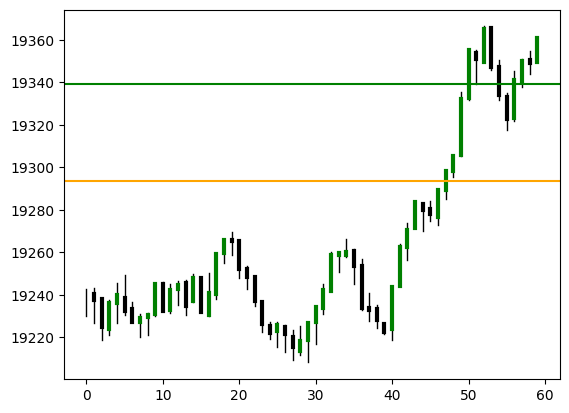

In [14]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
#step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

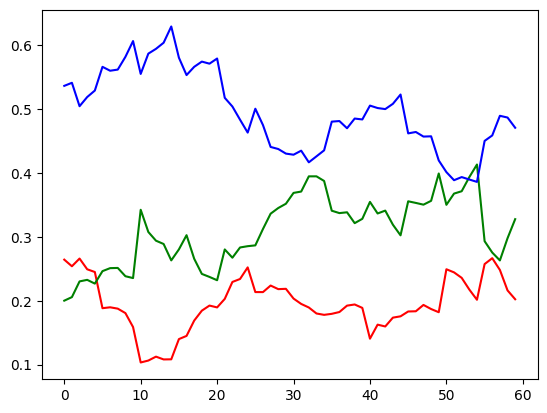

In [15]:
#plt.plot(outputs)
plt.plot([x[0] for x in outputs[-60:]], color="r")
plt.plot([x[1] for x in outputs[-60:]], color="g")
plt.plot([x[2] for x in outputs[-60:]], color="b")

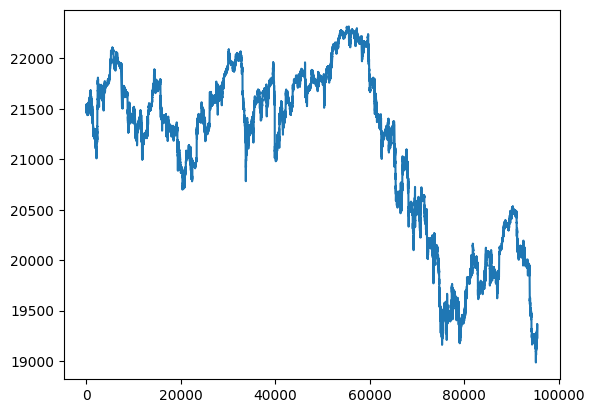

In [16]:
plt.plot([x.c for x in all_candles])

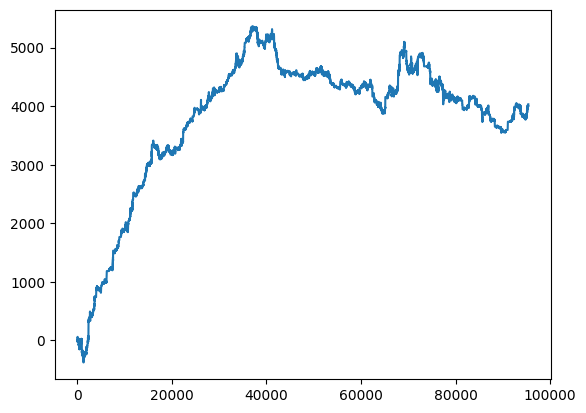

In [17]:
plt.plot(equity_L)

In [18]:
#plt.plot([x[1]-x[0] for x in outputs], color="b")